<a href="https://colab.research.google.com/github/ddlxdd/SOCI40133/blob/main/Xiaochen_Ding_5_Classifying_Meanings_and_Documents_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 - Classifying Meanings & Documents (With Machine Learning)

Recall that Week 1 of this course focused on how to find and extract text data, while weeks 2 through 4 each covered a different type of content representations:

2. computational linguistics (e.g., keyword count)
3. clustering and topic modeling (e.g., LDA)
4. embeddings (e.g., _word2vec_)

Now we show how classification, arguably the most common social science task, can be done with different representations. Note that the second representation, *clustering*, allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. Classification, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

We will show how to use a variety of classification methods, including Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data.

In [1]:
# run if on Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud

#All these packages need to be installed from pip
#For ML
import sklearn
# import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-5yxd0em_
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-5yxd0em_
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit b17a265d3b8253424e5b38872457f7437909a65d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Annotations

This is a course on "computational" content analysis, but the best computer today is arguably still the human brain (We'll see how far Large Language Models can go). Our aim is to augment human intelligence and scholarship. One of the most important strategies is to have real, live _Homo sapiens_ annotate text, assigning numbers or categories to individual texts. We can computationally compare annotations across humans, and we can use annotations to train computational models.

Let's take a quick look at Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/blob/main/data/loopdesign.png?raw=true" style="width:500px">

In [12]:
# Remember if you are on Google Colab, you need to upload or `git clone` the datafile
# and your path will probably be something like "#drive/MyDrive/{where you store on Google Drive}/data/pyAnno/testdata_numerical.txt"
x = np.loadtxt("/content/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [6]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [7]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [8]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [9]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


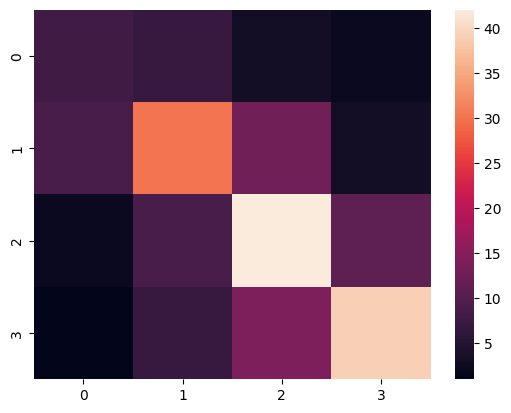

In [10]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [11]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [12]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [13]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [14]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [15]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


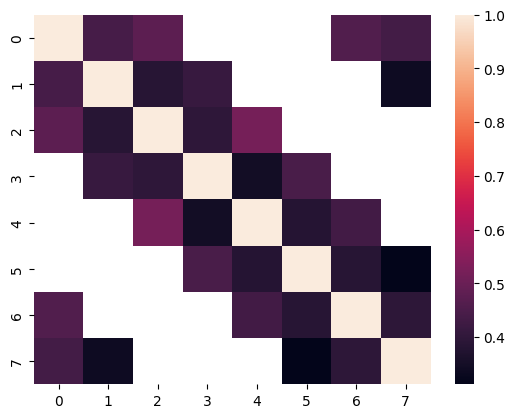

In [16]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others.

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [24]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)

pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [18]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [19]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

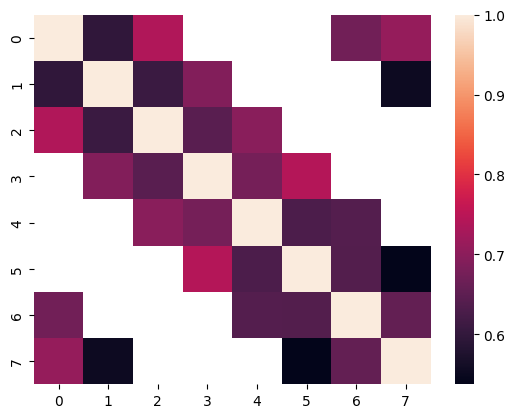

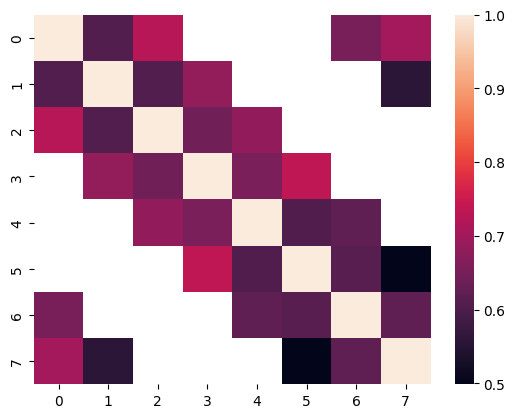

In [20]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [21]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <font color="red">*Exercise 1*</font>

<font color="red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the [MTurk slides on Canvas](https://canvas.uchicago.edu/courses/54694/files/folder/unfiled?preview=10675152), or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

In [25]:
sample_df = content_data_df.sample(n=20, random_state=42)

In [28]:
sample_df['Annotator_1'] = ''
sample_df['Annotator_2'] = ''
sample_df['Annotator_3'] = ''
sample_df['mood'] = ''

In [29]:
sample_df.to_csv('annotation_sample.csv', index=False)

In [6]:
import pandas as pd
df = pd.read_excel('annotation_sample.xlsx')

In [7]:
annotations = df[['Annotator_1', 'Annotator_2', 'Annotator_3']].to_numpy()

In [8]:
annotations

array([[2, 2, 2],
       [1, 1, 2],
       [1, 1, 0],
       [2, 1, 1],
       [2, 2, 2],
       [0, 0, 0],
       [1, 1, 1],
       [0, 1, 0],
       [0, 0, 0],
       [2, 1, 2],
       [0, 2, 2],
       [0, 0, 0],
       [2, 2, 2],
       [2, 2, 2],
       [1, 1, 1],
       [2, 2, 2],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [2, 1, 2]])

In [15]:
label_freq = pyanno.measures.agreement.labels_frequency(anno.annotations,3)
print('Label frequency:\n', label_freq)

Label frequency:
 [0.11666667 0.245      0.34083333 0.2975    ]


In [17]:
c = pyanno.measures.agreement.confusion_matrix(annotations[:, 0], annotations[:, 1], 4)
print('Confusion matrix:\n', c)

Confusion matrix:
 [[6. 1. 1. 0.]
 [0. 4. 0. 0.]
 [0. 3. 5. 0.]
 [0. 0. 0. 0.]]


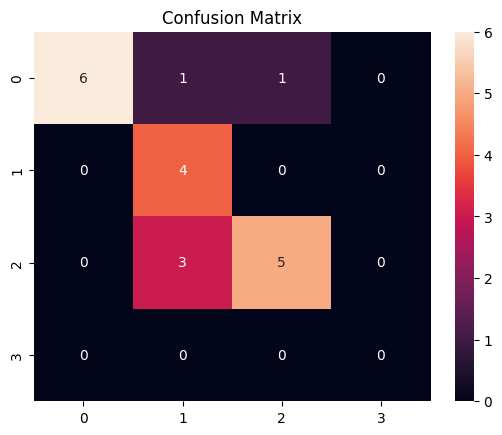

In [19]:
seaborn.heatmap(c, annot=True)
plt.title('Confusion Matrix')
plt.show()

In [20]:
scotts_pi_value = cohens_kappa(annotations[:, 0], annotations[:, 1])
print('Scott\'s Pi:', scotts_pi_value)

Scott's Pi: 0.6323529411764707


In [21]:
m = pairwise_matrix(cohens_kappa, annotations)
print('Pairwise Cohen\'s Kappa:\n', m)

Pairwise Cohen's Kappa:
 [[1.         0.63235294 0.68253968]
 [0.63235294 1.         0.6350365 ]
 [0.68253968 0.6350365  1.        ]]


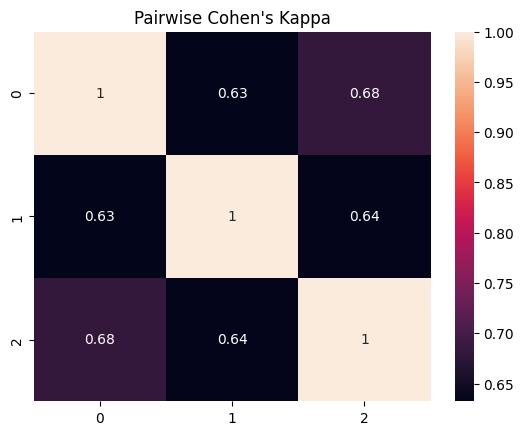

In [22]:
seaborn.heatmap(m, annot=True)
plt.title('Pairwise Cohen\'s Kappa')
plt.show()

In [25]:
# Average pairwise Cohen's Kappa
average_cohens_kappa = pairwise_metric_average(cohens_kappa, annotations)
print('Average pairwise Cohen\'s Kappa:', average_cohens_kappa)

Average pairwise Cohen's Kappa: 0.6499763733555061


<Axes: >

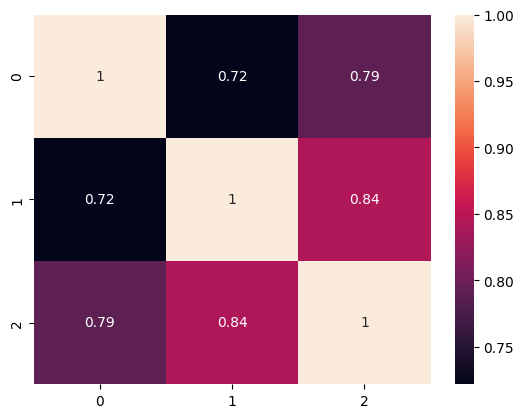

In [26]:
from scipy.stats import spearmanr

# Pearson's Rho
def pearsons_rho(annotations):
    return np.corrcoef(annotations.T)

# Spearman's Rho
def spearmans_rho(annotations):
    rho_matrix = np.zeros((annotations.shape[1], annotations.shape[1]))
    for i in range(annotations.shape[1]):
        for j in range(annotations.shape[1]):
            rho, pval = spearmanr(annotations[:, i], annotations[:, j])
            rho_matrix[i, j] = rho
    return rho_matrix

# Pairwise correlation coefficients
pearsons_rho_matrix = pearsons_rho(annotations)
spearmans_rho_matrix = spearmans_rho(annotations)

# Heatmaps of pairwise correlation coefficients
seaborn.heatmap(pearsons_rho_matrix, annot=True)

**Scott's Pi**: A value of approximately 0.632 indicates a good level of agreement between two annotators beyond what would be expected by chance alone.

**Pairwise Cohen's Kappa**: The matrix shows the Cohen's Kappa scores for each pair of annotators, with 1 indicating perfect self-agreement (the diagonal). The other values range from approximately 0.632 to 0.683, indicating a substantial agreement between the annotators. These values suggest that the annotators are relatively consistent in their assessments.

**Average Pairwise Cohen's Kappa**: An average of approximately 0.65 across all pairs of annotators also indicates substantial agreement. This average kappa value is a good indicator that the annotations are reliable overall.

# Simple Simulated Examples for Classification

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`).

The four data patterns include:
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

We use the popular `train_test_split()` function from `sklearn`, and the data pattern function source code is copied below for your convenience from `lucem_illud`'s [cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py) file.

In [ ]:
def random(numPerCategory = 500):
    datDict = {
        'vect' : [np.random.rand(2) * 2 - 1 for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def andSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        y = np.random.random_sample() * 2 - 1
        if noise >= 0:
            x = np.random.random_sample() - cat - (np.random.random_sample() - cat) * noise
        else:
            x = (1 - noise * np.random.random_sample()) - cat
        return np.array([x, y])
    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def xorSplit(noise = 0, numPerCategory = 500):
    def genPoint(cat):
        if cat == 1:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        else:
            if np.random.randint(0,2) < 1:
                y = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - np.random.random_sample() * noise * 2
            else:
                y = np.random.random_sample() - np.random.random_sample() * noise * 2
                x = np.random.random_sample() - 1 - np.random.random_sample() * noise * 2
        return np.array([x, y])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def targetSplit(noise = 0, numPerCategory = 500, innerRad = .3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect' : [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category' : [i % 2 for i in range(2 * numPerCategory)],
    }

    return pandas.DataFrame(datDict)

def multiBlobs(noise = 0, numPerCategory = 500, centers = 5):
    if isinstance(centers, int):
        n_samples = numPerCategory * centers
    else:
        n_samples = numPerCategory * len(centers)
    X, y = sklearn.datasets.make_blobs(n_samples=n_samples, centers=centers, cluster_std = (.8 * (noise * 2 + 1)))
    datDict = {
        'vect' : list(X),
        'category' : y,
    }
    return pandas.DataFrame(datDict)

In [ ]:
noise = .2

#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.random(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.andSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.xorSplit(noise), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.targetSplit(noise), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.multiBlobs(noise), test_size=.2)

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [ ]:
dfTrain

So, dfTrain has two columns, vect and category. We can plot this with `plotter()` from [lucem_illud/lucem_illud/cartoons.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/cartoons.py). Here's the source code:

In [ ]:
def plotter(df):
    fig, ax = plt.subplots(figsize = (10,10))
    pallet = seaborn.color_palette(palette='rainbow', n_colors= len(set(df['category'])))
    for i, cat in enumerate(set(df['category'])):
        a = np.stack(df[df['category'] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[i], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    ax.axis('off')
    plt.show()
    plt.close()

In [ ]:
lucem_illud.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [ ]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [ ]:
dir(sklearn)

Now we fit the model by giving it our training data

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [ ]:
dfTrain['vect']

And let's see what np.stack(dfTrain['vect']) does:

In [ ]:
np.stack(dfTrain['vect'])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set. These `lucem_illud` functions are in [metrics.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/metrics.py), and we will skip copying source code this time due to length.

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

This lets us look at which classes do better:

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

Note that if you're on Google Colab and have not `git clone`ed the [class repo](https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter), you can set a `dataDirectory=` parameter in the loadReddit function to match the data folder path on Colab.

In [ ]:
# dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory='../data/'), test_size=.2)
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory=''), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(), test_size=.2)
#dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(), test_size=.2)

In [ ]:
dfTrain

In [ ]:
#Classical Regression
clf = sklearn.linear_model.LogisticRegression()

#Bayes
# clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [ ]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf, dfTest)

In [ ]:
lucem_illud.plotConfusionMatrix(clf, dfTest)

In [ ]:
lucem_illud.plotMultiROC(clf, dfTest)

In [ ]:
lucem_illud.plotregions(clf, dfTrain)

## <font color="red">*Exercise 2*</font>

<font color="red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<font color="red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn import datasets, model_selection, neighbors, metrics

# Generate an artificial dataset using the targetSplit function
def targetSplit(noise=0.2, numPerCategory=500, innerRad=0.3):
    def genPoint(cat):
        if cat == 0:
            r = np.random.random_sample() * innerRad + (1 - innerRad) * np.random.random_sample() * noise
        else:
            r = np.random.random_sample() * (1 - innerRad) + innerRad - innerRad * np.random.random_sample() * noise
        eta = 2 * np.pi * np.random.random_sample()
        return np.array([r * np.cos(eta), r * np.sin(eta)])

    datDict = {
        'vect': [genPoint(i % 2) for i in range(2 * numPerCategory)],
        'category': [i % 2 for i in range(2 * numPerCategory)],
    }

    return pd.DataFrame(datDict)

# Generate dataset
df = targetSplit()

In [31]:
df

,vect,category
0,"[0.010074216519644996, -0.027809888947735555]",0
1,"[0.39274984700040694, -0.24003064170092617]",1
2,"[-0.0346545638343585, -0.09150817210524854]",0
3,"[0.16708121362762599, -0.8333592564362463]",1
4,"[0.122137372692387, 0.15457472573836495]",0
...,...,...
995,"[-0.7484580303831352, 0.2044655590455947]",1
996,"[-0.09512008830143126, -0.09474272503997691]",0
997,"[-0.2585380546142363, -0.3786073714112768]",1
998,"[0.2773537481800834, 0.05073448240674974]",0


In [32]:
# Split dataset into training and testing
dfTrain, dfTest = model_selection.train_test_split(df, test_size=0.2)


In [38]:
# Logistic Regression
clf = LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

LogisticRegression()

Logistic Regression           Error_Rate     AUC  Precision  Average_Precision    Recall
Category                                                            
0              0.495  0.5048   0.509615           0.507422  0.524752
1              0.495  0.5048   0.500000           0.497424  0.484848


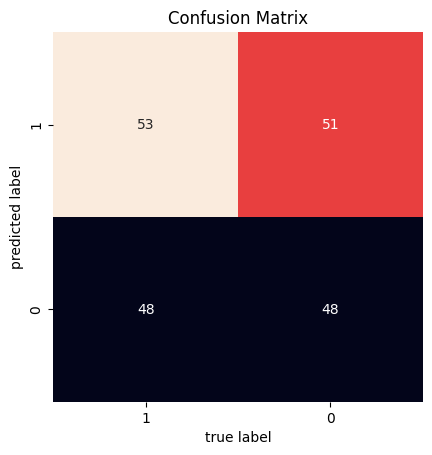

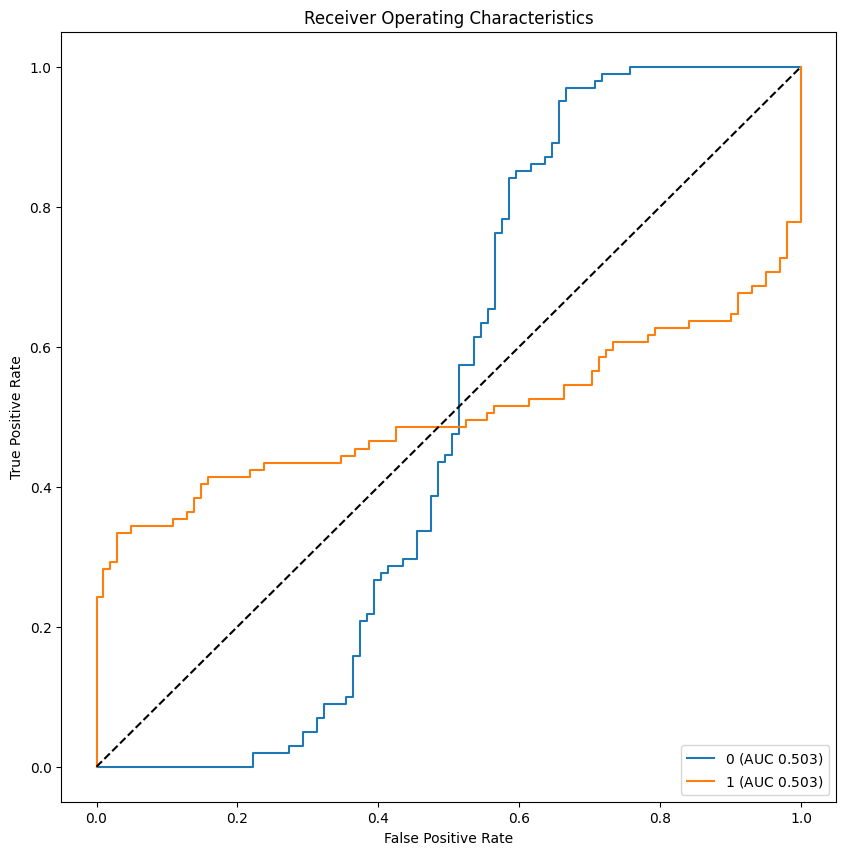

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


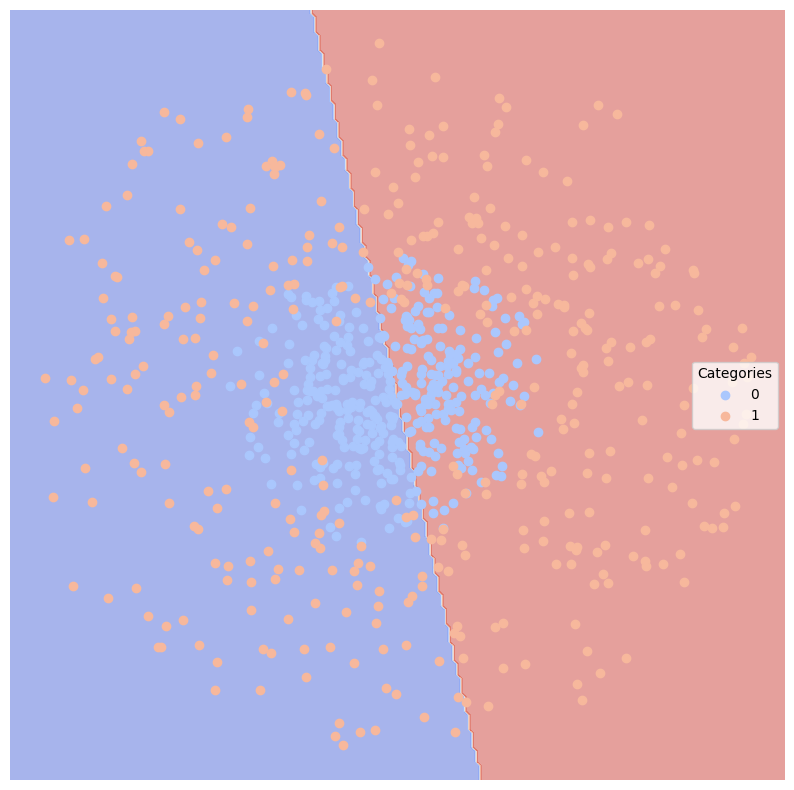

In [42]:
# Evaluate the classifier
print("Logistic Regression",lucem_illud.evaluateClassifier(clf, dfTest))


# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf, dfTrain)

Naive Bayes           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.115  0.884438   0.848214           0.827825  0.940594
1              0.115  0.884438   0.931818           0.856809  0.828283


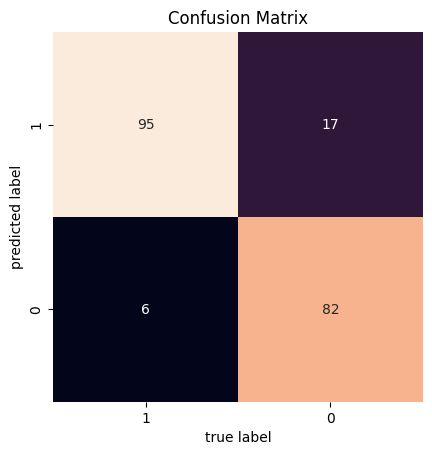

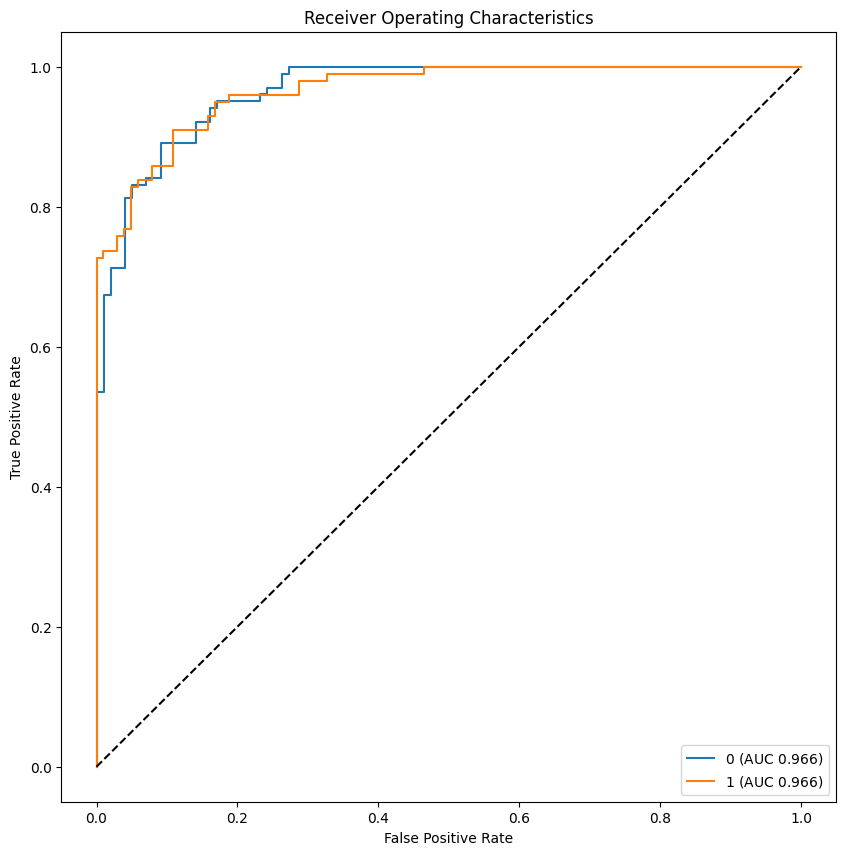

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


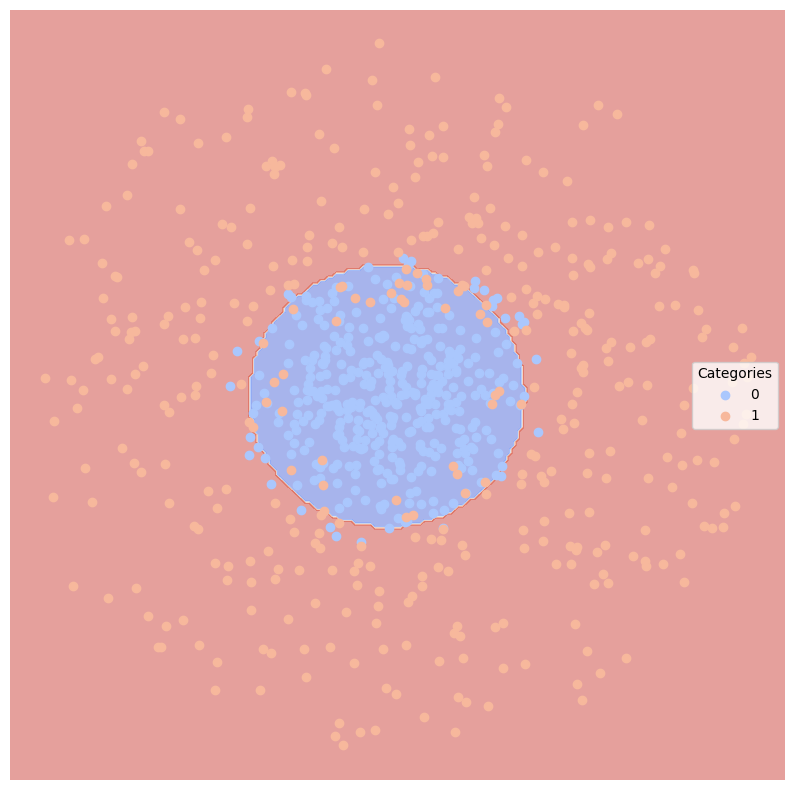

In [43]:
# Naive Bayes
clf_nb = GaussianNB()
clf_nb.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("Naive Bayes", lucem_illud.evaluateClassifier(clf_nb, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_nb, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_nb, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_nb, dfTrain)

SVM Linear Kernel           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.375  0.622712   0.589041           0.576560  0.851485
1              0.375  0.622712   0.722222           0.584512  0.393939


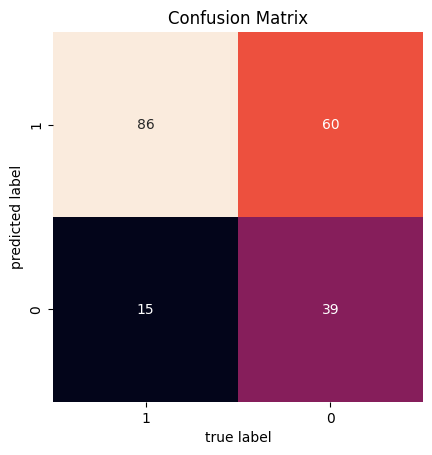

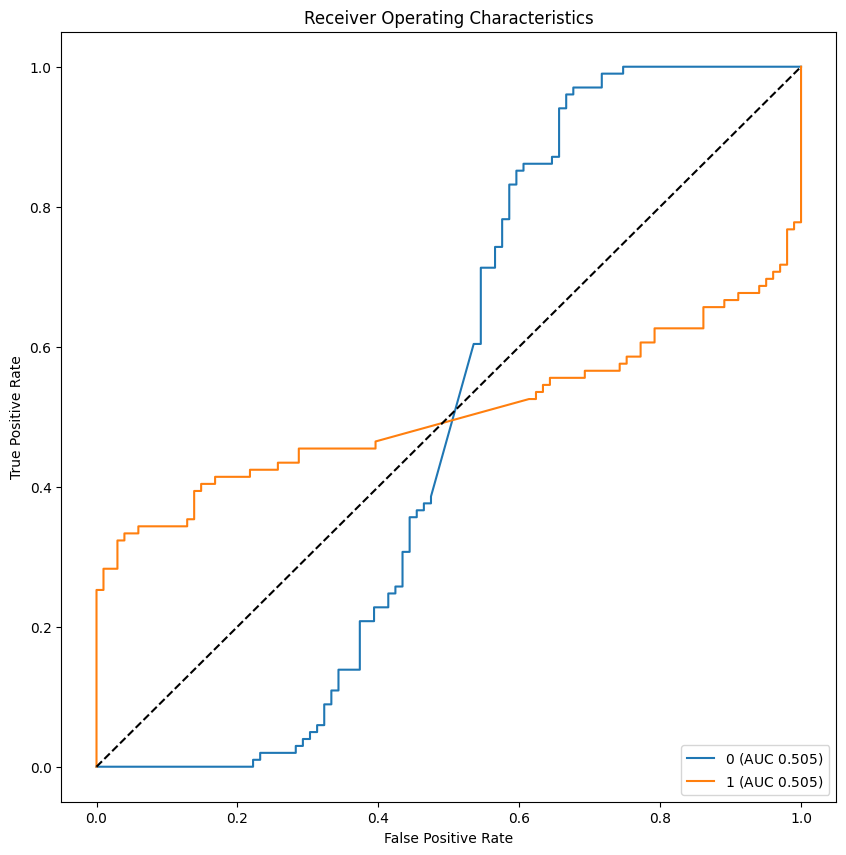

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


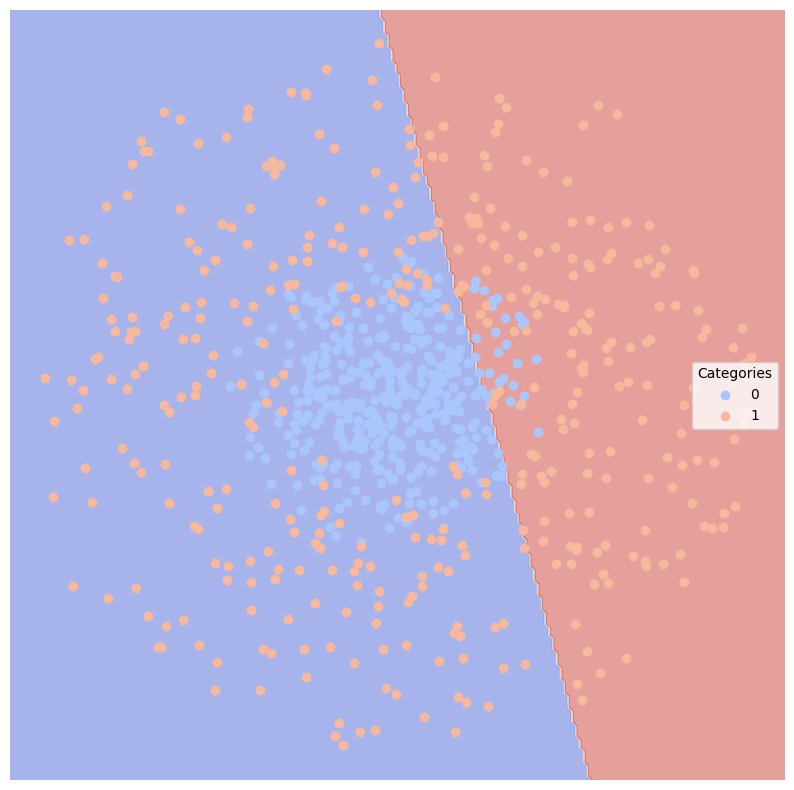

SVM Polynomial Kernel           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.41  0.585859   0.551913           0.551913  1.000000
1               0.41  0.585859   1.000000           0.581717  0.171717


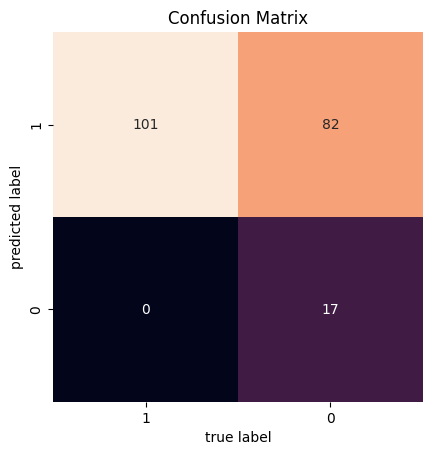

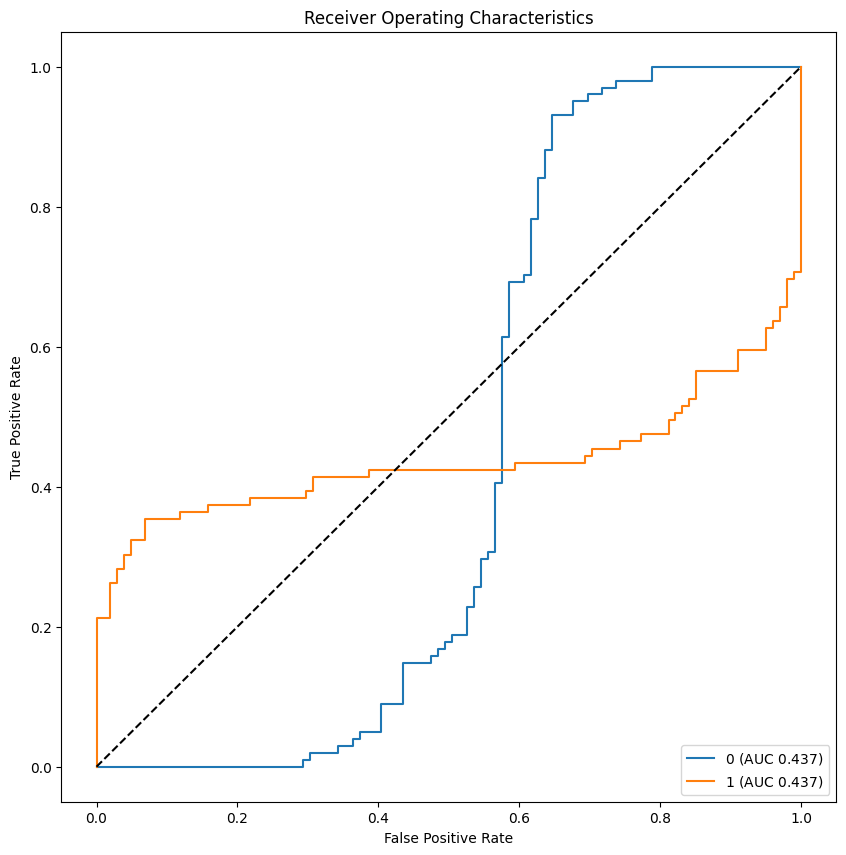

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


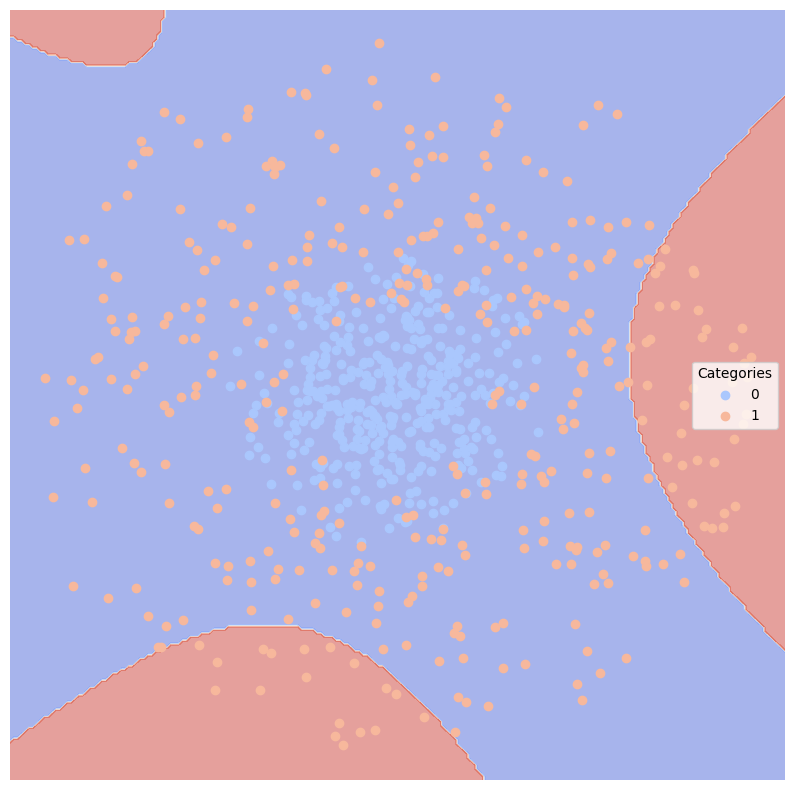

In [44]:
# SVM with Linear Kernel
clf_svm_linear = SVC(kernel='linear', probability=True)
clf_svm_linear.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("SVM Linear Kernel", lucem_illud.evaluateClassifier(clf_svm_linear, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_svm_linear, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_svm_linear, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_svm_linear, dfTrain)

# SVM with Polynomial Kernel
clf_svm_poly = SVC(kernel='poly', degree=3, probability=True)
clf_svm_poly.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("SVM Polynomial Kernel", lucem_illud.evaluateClassifier(clf_svm_poly, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_svm_poly, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_svm_poly, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_svm_poly, dfTrain)

K-Nearest Neighbors           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.12  0.879188   0.829060           0.816226  0.960396
1               0.12  0.879188   0.951807           0.859523  0.797980


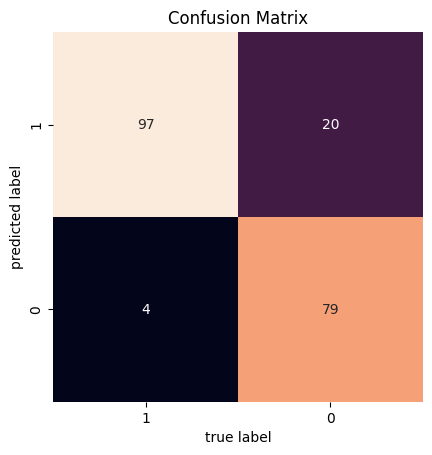

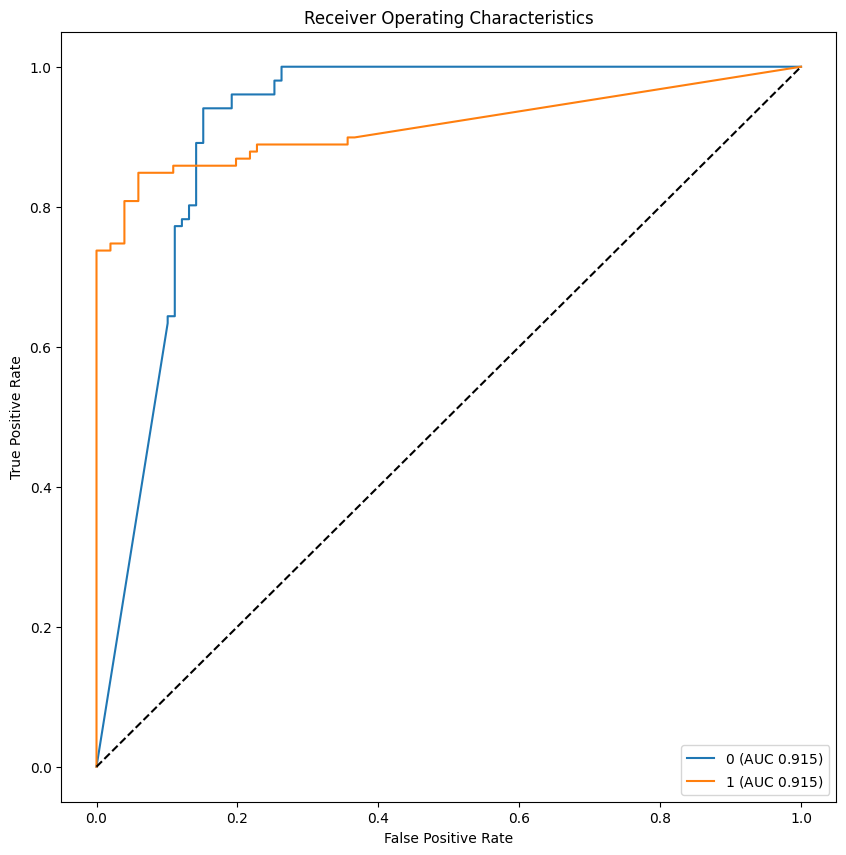

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


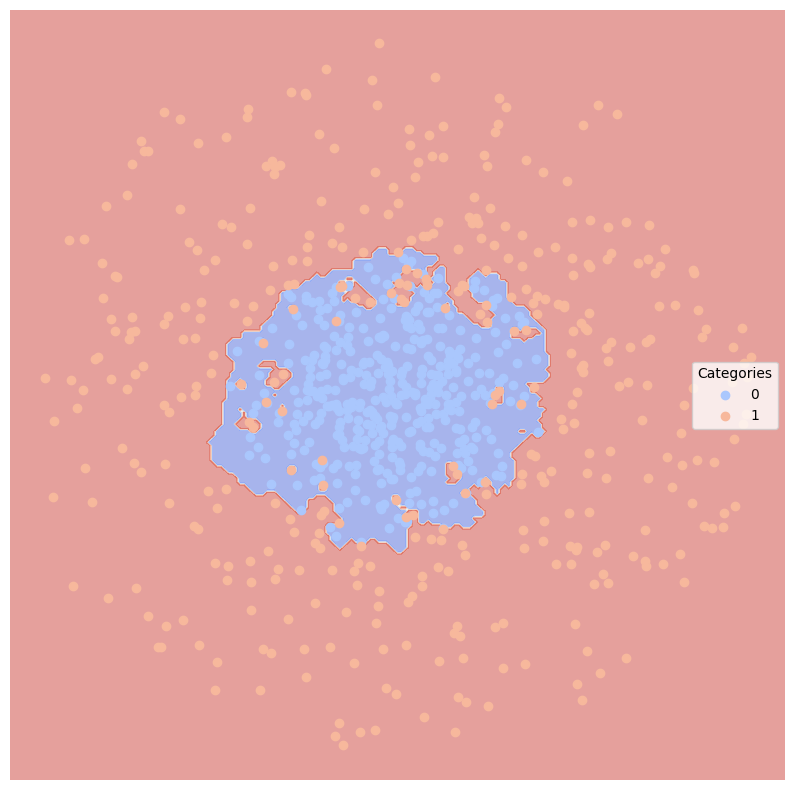

In [45]:
# K-Nearest Neighbors
clf_knn = KNeighborsClassifier(5, weights='distance')
clf_knn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("K-Nearest Neighbors", lucem_illud.evaluateClassifier(clf_knn, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_knn, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_knn, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_knn, dfTrain)

Decision Tree           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.11  0.889689   0.869159           0.840315  0.920792
1               0.11  0.889689   0.913978           0.854729  0.858586


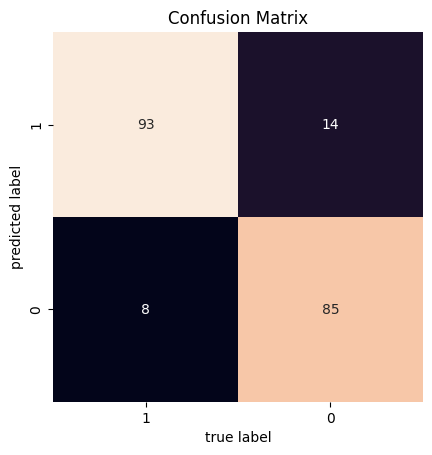

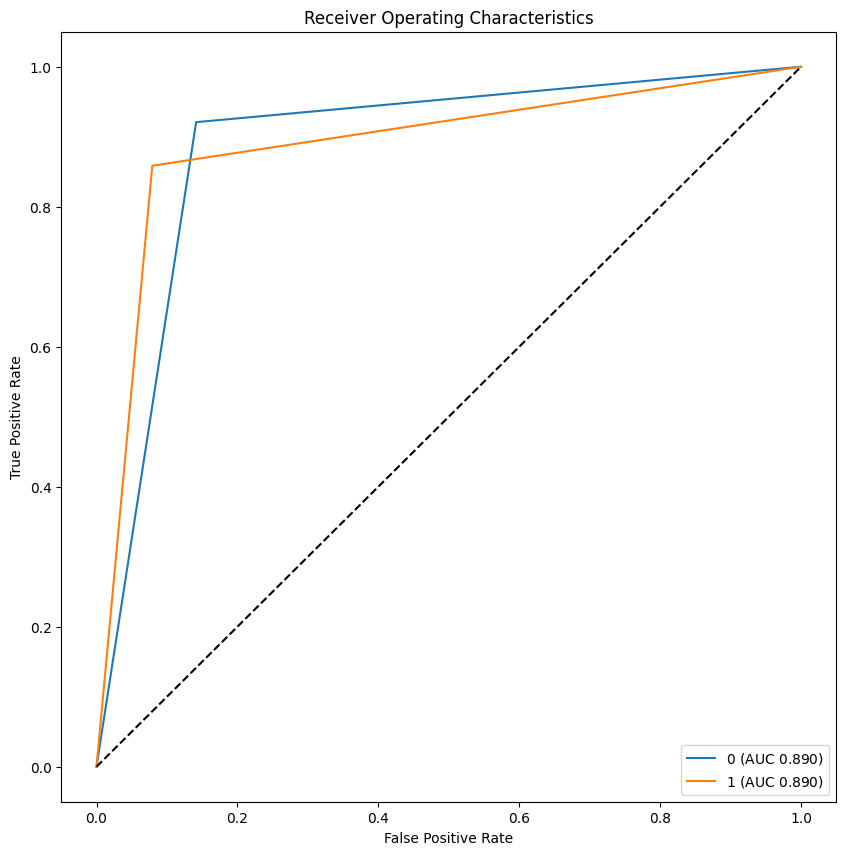

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


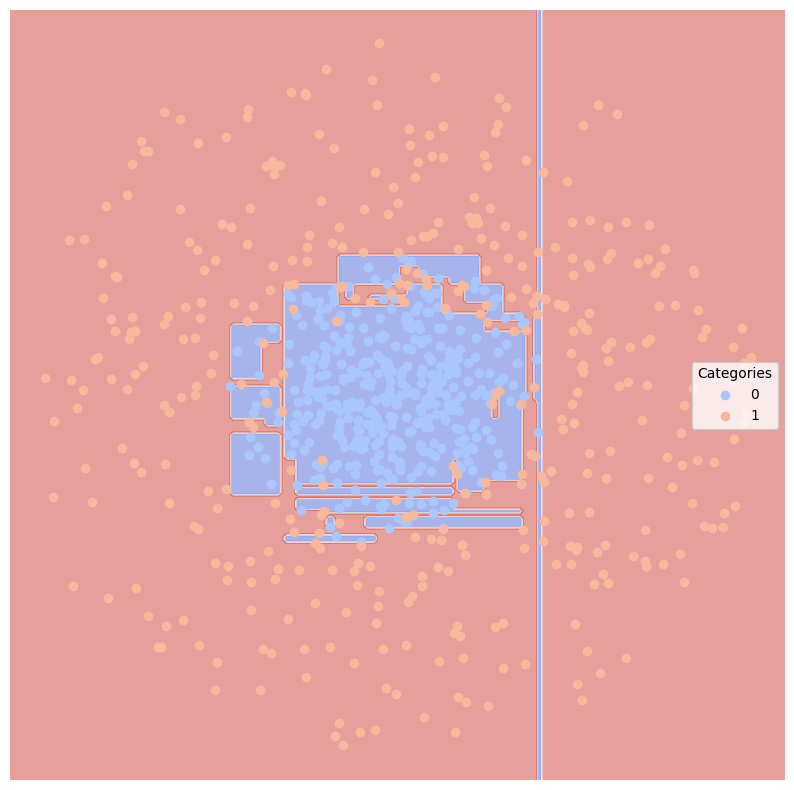

Random Forest           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0              0.135  0.864436   0.830357           0.804586  0.920792
1              0.135  0.864436   0.909091           0.829619  0.808081


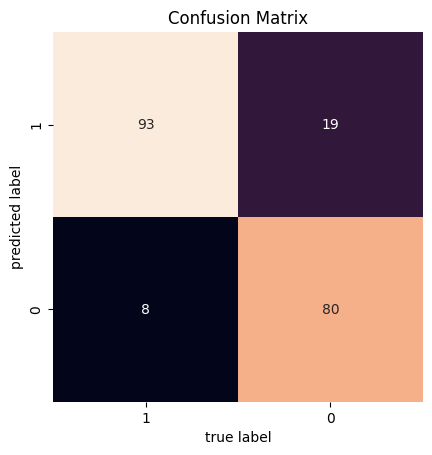

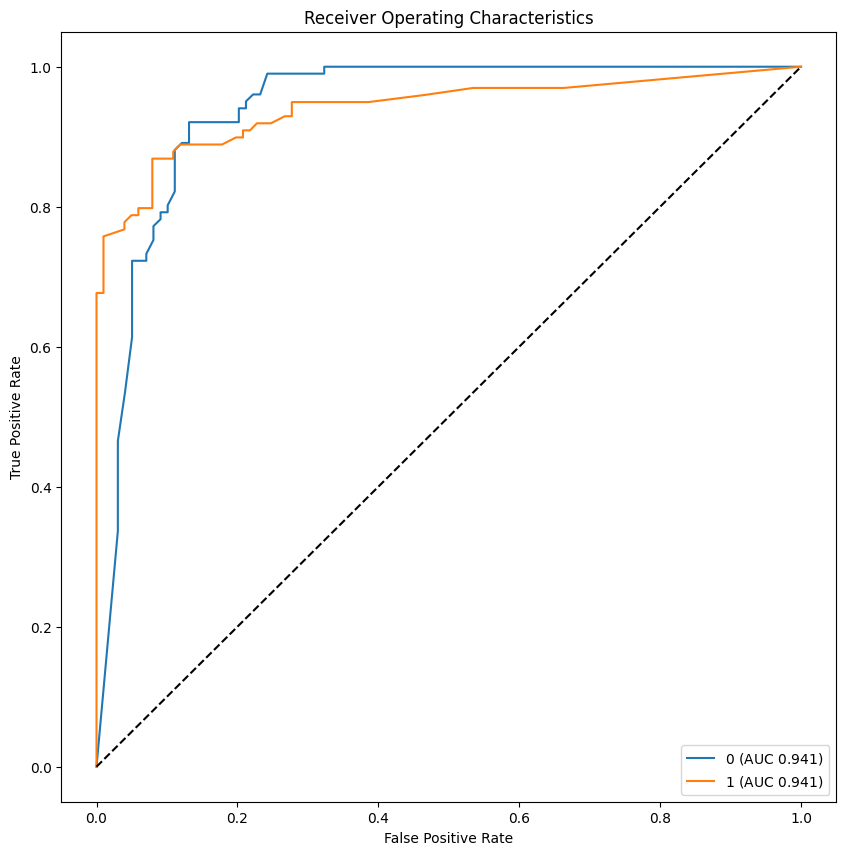

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


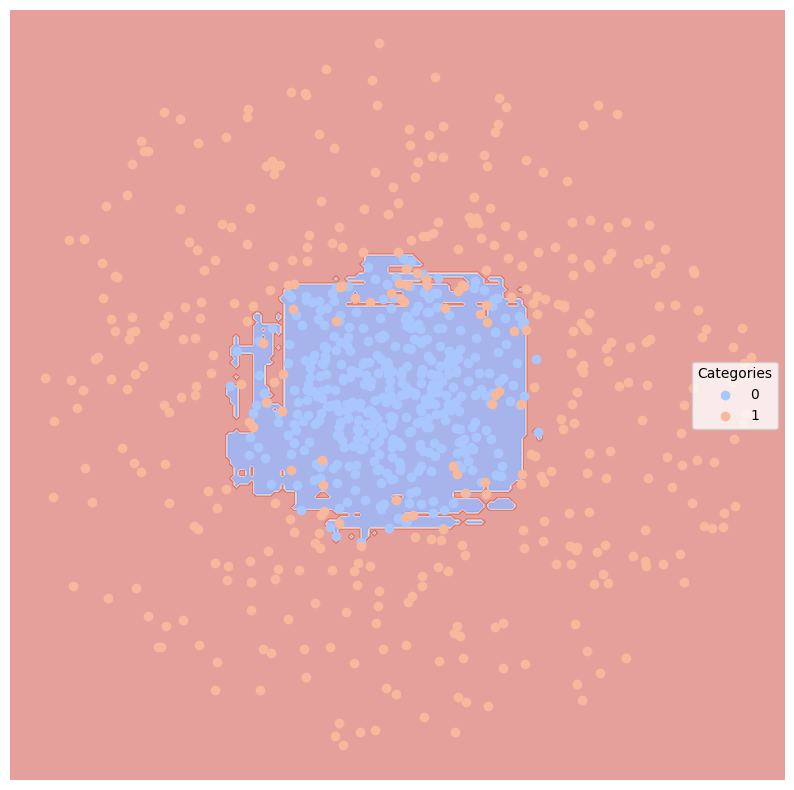

In [46]:
# Decision Tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("Decision Tree", lucem_illud.evaluateClassifier(clf_dt, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_dt, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_dt, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_dt, dfTrain)

# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("Random Forest", lucem_illud.evaluateClassifier(clf_rf, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_rf, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_rf, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_rf, dfTrain)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP           Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                              
0               0.14  0.859086   0.806723           0.791786  0.950495
1               0.14  0.859086   0.938272           0.835289  0.767677


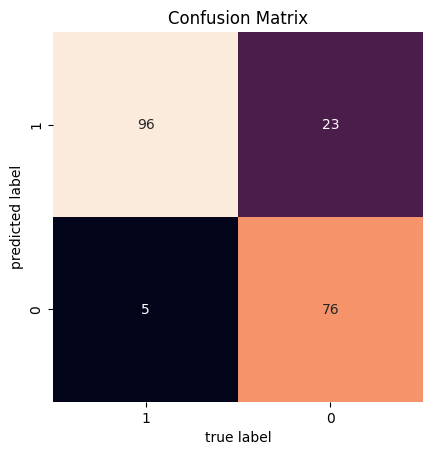

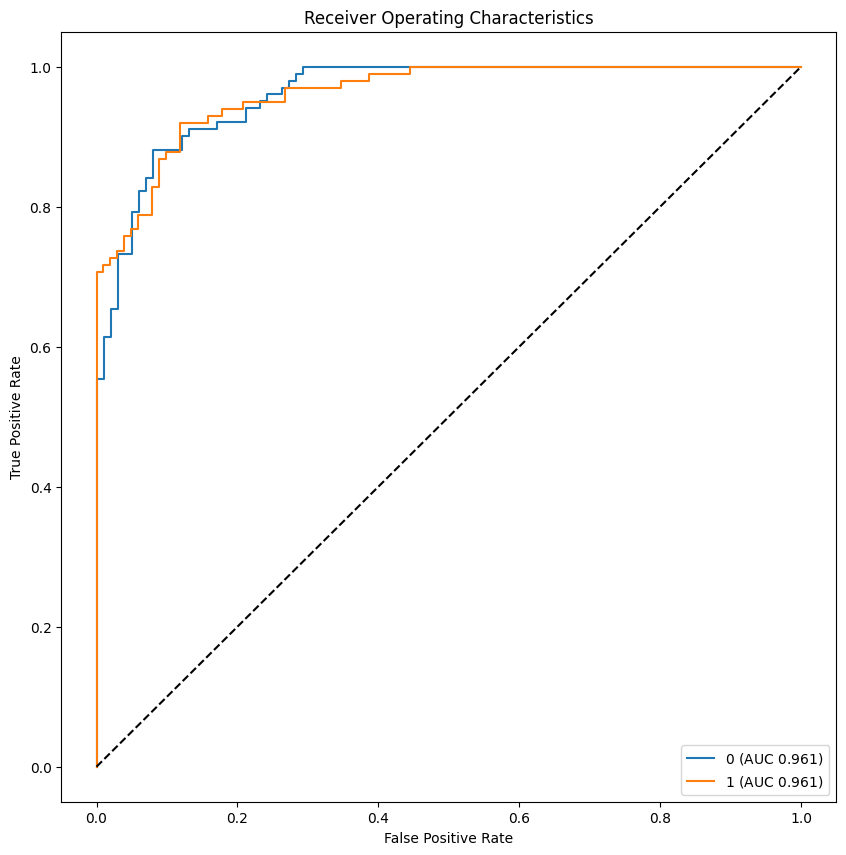

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


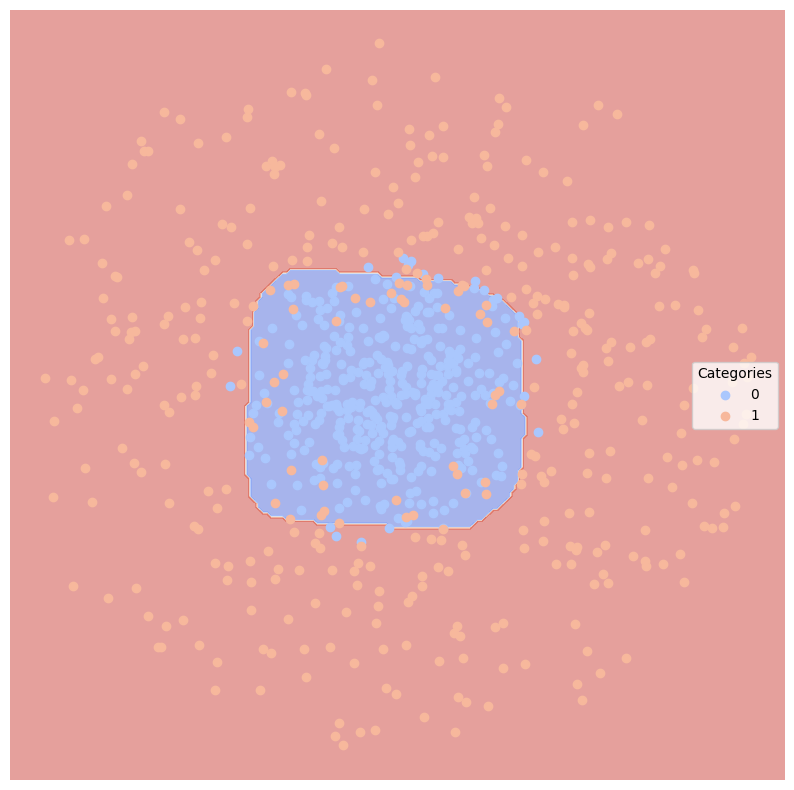

In [47]:
# MLP
clf_mlp = MLPClassifier()
clf_mlp.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("MLP", lucem_illud.evaluateClassifier(clf_mlp, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_mlp, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_mlp, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_mlp, dfTrain)

Gradient Boosting           Error_Rate      AUC  Precision  Average_Precision    Recall
Category                                                             
0              0.095  0.90424   0.853448           0.846548  0.980198
1              0.095  0.90424   0.976190           0.893562  0.828283


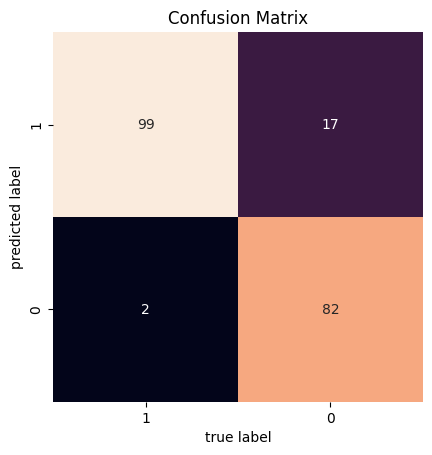

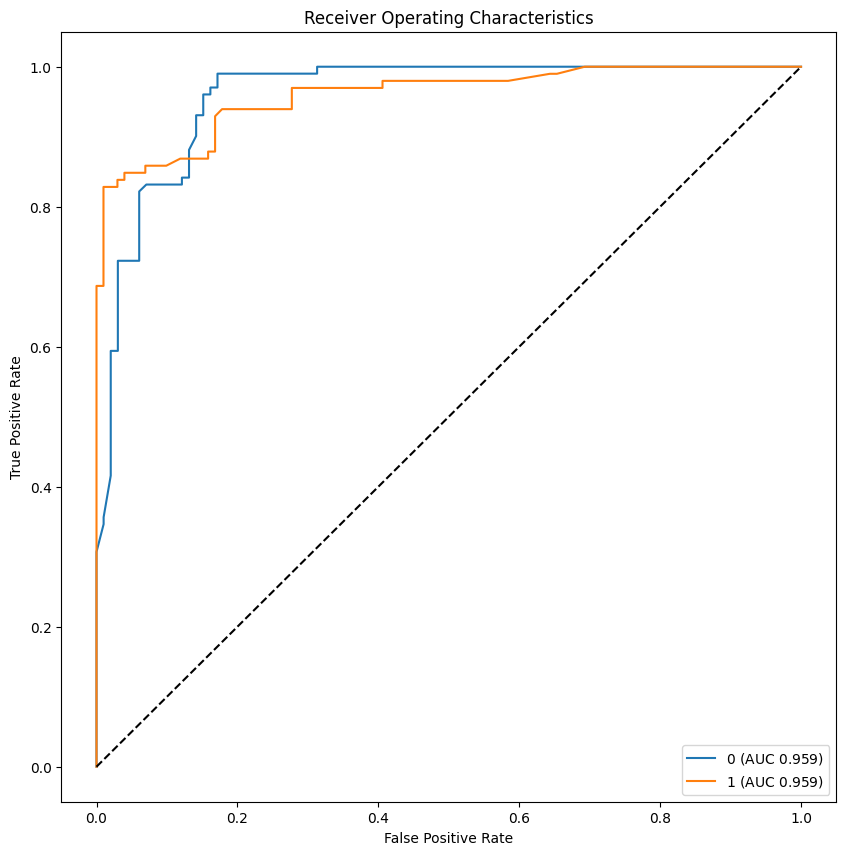

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


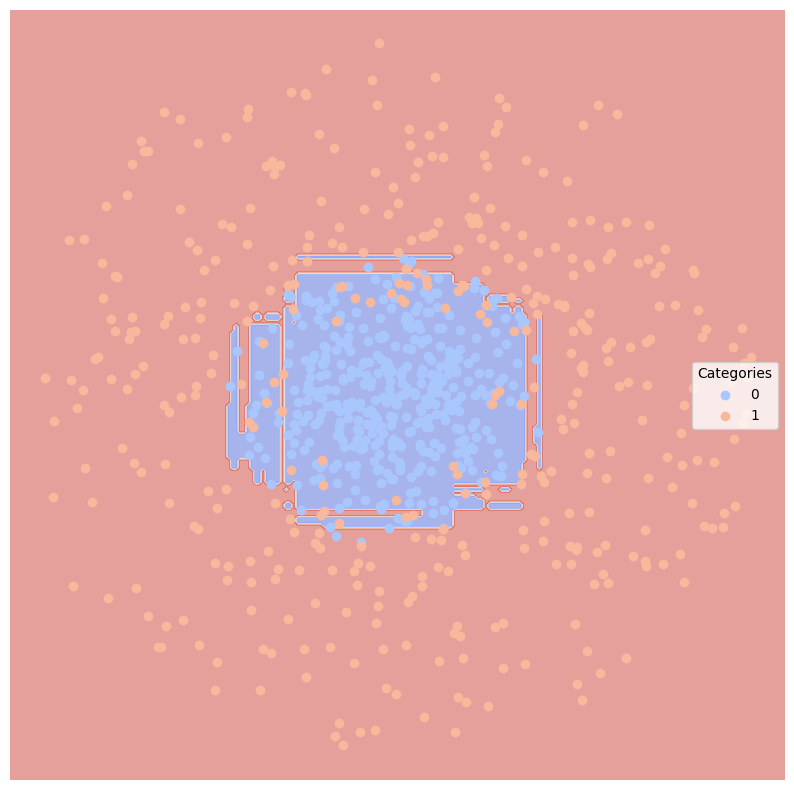

In [48]:
# Gradient Boosting
clf_gb = GradientBoostingClassifier()
clf_gb.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

# Evaluate the classifier
print("Gradient Boosting", lucem_illud.evaluateClassifier(clf_gb, dfTest))

# Plot confusion matrix
lucem_illud.plotConfusionMatrix(clf_gb, dfTest)

# Plot ROC curves
lucem_illud.plotMultiROC(clf_gb, dfTest)

# Visualize decision regions
lucem_illud.plotregions(clf_gb, dfTrain)

## Gradient Boosting

**Best Performance Overall**: Gradient Boosting demonstrated the highest AUC and lowest error rate, along with strong precision and recall across both categories. This suggests it was most effective at handling complex, non-linear decision boundaries that may have been present in the dataset.

## Naive Bayes
**Strong Performance, Especially in Recall for Category 0**: Naive Bayes showed a significant improvement in AUC, precision, and recall for category 0 over Logistic Regression, indicating its strength in distinguishing category 0 instances from category 1.

## K-Nearest Neighbors (KNN)
**High Precision and Recall**: KNN showed balanced and strong performance across all metrics. This indicates its effectiveness in classifying instances based on their proximity to neighbors in the feature space.

## Decision Tree and Random Forest
**Robust Performance**: Both showed good balance between precision and recall, indicating effective classification capabilities. Random Forest, as an ensemble of Decision Trees, slightly lagged behind in AUC and error rate compared to the top performer but still demonstrated strong capabilities.

## Support Vector Machines (SVM)
**Variable Performance**: The SVM with a linear kernel showed moderate performance, while the SVM with a polynomial kernel had high precision for category 1 but lower recall. This indicates the SVM's sensitivity to the choice of kernel and its parameters.


## Multi-Layer Perceptron (MLP)
**Good Recall for Category 0**: MLP showed good recall for category 0 and precision for category 1, suggesting its capability to model complex relationships between features.

In [61]:
!git clone https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter.git


Cloning into 'Homework-Notebooks-2024-Winter'...
remote: Enumerating objects: 4108, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4108 (delta 15), reused 40 (delta 12), pack-reused 4060
Receiving objects: 100% (4108/4108), 189.37 MiB | 39.41 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Updating files: 100% (4061/4061), done.


In [9]:
# Reddit
dfTrain, dfTest = sklearn.model_selection.train_test_split(lucem_illud.loadReddit(dataDirectory=''), test_size=.2)


Loading Reddit data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [16]:
# Newsgroups
dfTrain_ng, dfTest_ng = sklearn.model_selection.train_test_split(lucem_illud.loadNewsGroups(), test_size=.2)

Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [17]:
# Senate Small

dfTrain_ss, dfTest_ss = sklearn.model_selection.train_test_split(lucem_illud.loadSenateSmall(dataDirectory=''), test_size=.2)

Loading senate data
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [18]:
# Senate Large
dfTrain_sl, dfTest_sl = sklearn.model_selection.train_test_split(lucem_illud.loadSenateLarge(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)

Loading senator: Klobuchar
Loading senator: Kerry
Loading senator: Kyl
Loading senator: Kennedy
Loading senator: Kohl
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [19]:
# Email Spam
dfTrain_spam, dfTest_spam = sklearn.model_selection.train_test_split(lucem_illud.loadSpam(dataDirectory='/content/Homework-Notebooks-2024-Winter/data'), test_size=.2)

Loading Spam
Loading Ham
Converting to vectors


/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


## Reddit

Logistic Regression on Reddit Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships              0.028125  0.961764   0.951807           0.910777   
Bad Roommates              0.015625  0.985224   0.949367           0.940000   
Tales From Tech Support    0.012500  0.978938   0.987013           0.958906   
Weeaboo Tales              0.006250  0.991735   0.987654           0.978586   

                           Recall  
Category                           
Relationships            0.940476  
Bad Roommates            0.986842  
Tales From Tech Support  0.962025  
Weeaboo Tales            0.987654  


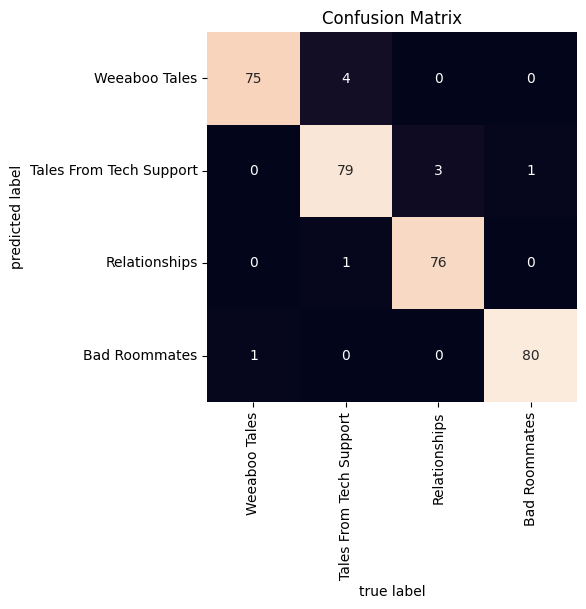

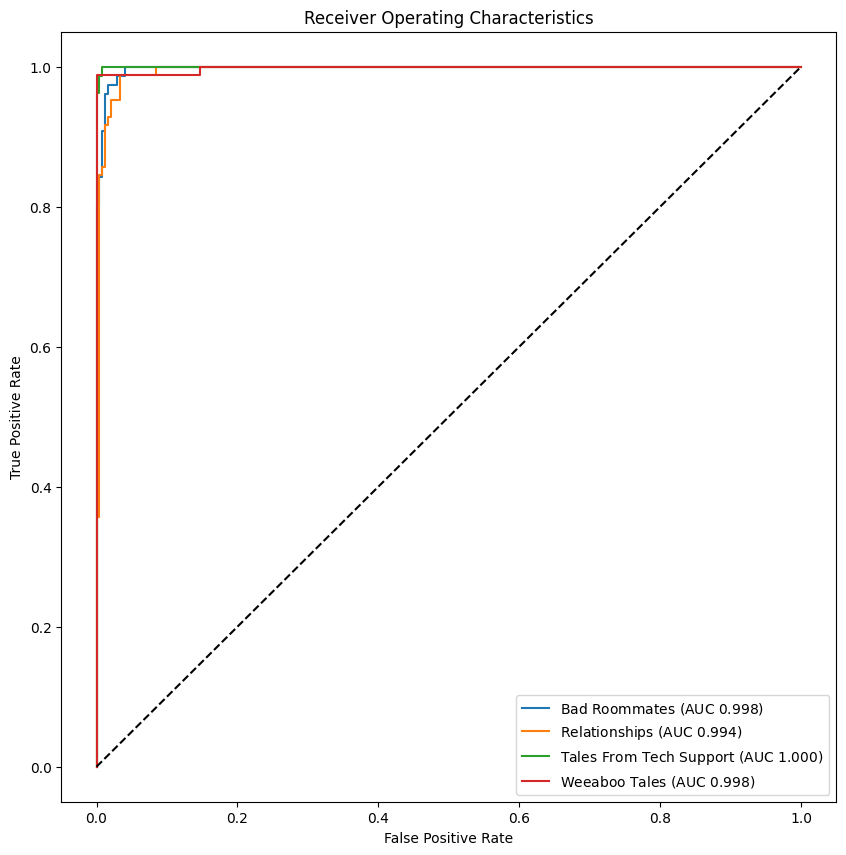

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


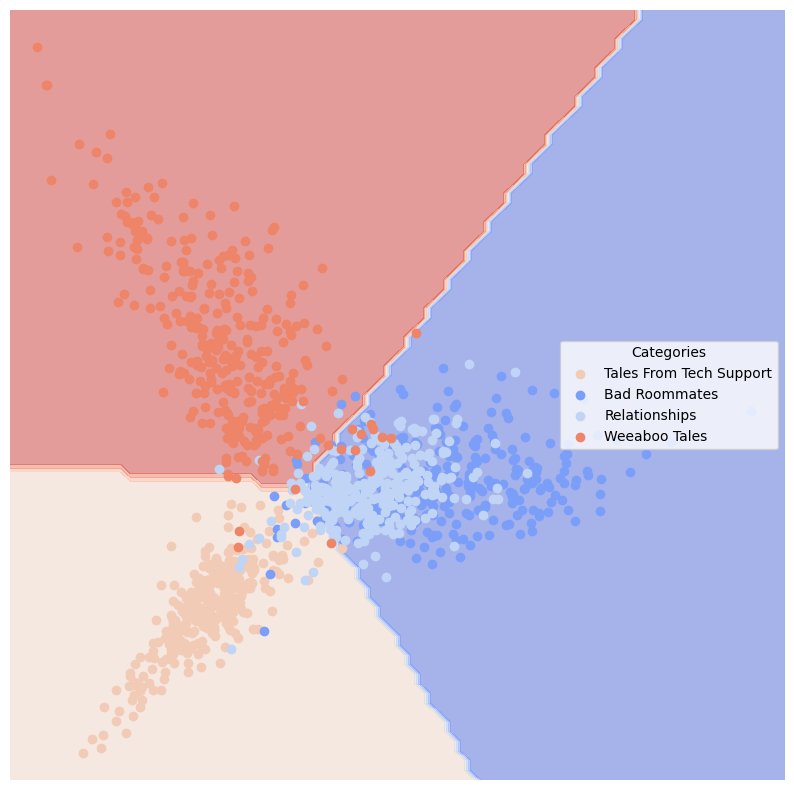

In [72]:
clf = LogisticRegression()
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("Logistic Regression on Reddit Dataset", lucem_illud.evaluateClassifier(clf, dfTest))
lucem_illud.plotConfusionMatrix(clf, dfTest)
lucem_illud.plotMultiROC(clf, dfTest)
lucem_illud.plotregions(clf, dfTrain)

Naive Bayes on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships              0.156250  0.729217   0.854167           0.551290   
Bad Roommates              0.121875  0.843076   0.728395           0.618590   
Tales From Tech Support    0.062500  0.886181   0.953846           0.801713   
Weeaboo Tales              0.171875  0.864533   0.603175           0.581567   

                           Recall  
Category                           
Relationships            0.488095  
Bad Roommates            0.776316  
Tales From Tech Support  0.784810  
Weeaboo Tales            0.938272  


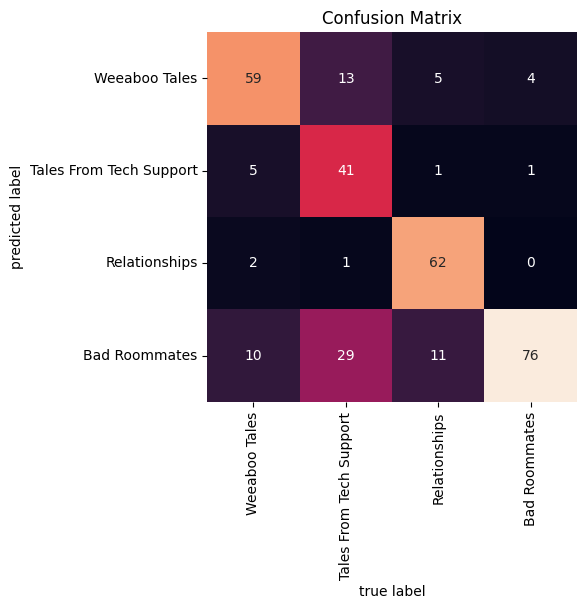

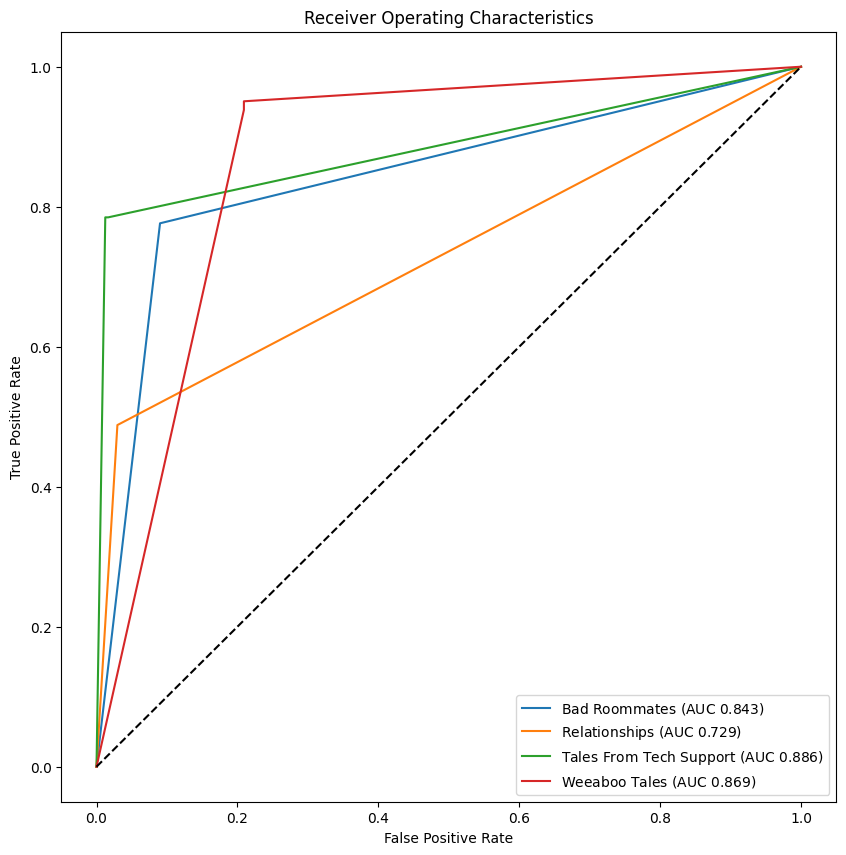

In [73]:
# Naive Bayes
clf_nb = GaussianNB()
clf_nb.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("Naive Bayes on Dataset", lucem_illud.evaluateClassifier(clf_nb, dfTest))
lucem_illud.plotConfusionMatrix(clf_nb, dfTest)
lucem_illud.plotMultiROC(clf_nb, dfTest)

SVM Linear Kernel on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Relationships               0.01875  0.971953   0.975610           0.941652   
Bad Roommates               0.01875  0.983175   0.937500           0.928289   
Tales From Tech Support     0.00625  0.987342   1.000000           0.980934   
Weeaboo Tales               0.00625  0.991735   0.987654           0.978586   

                           Recall  
Category                           
Relationships            0.952381  
Bad Roommates            0.986842  
Tales From Tech Support  0.974684  
Weeaboo Tales            0.987654  


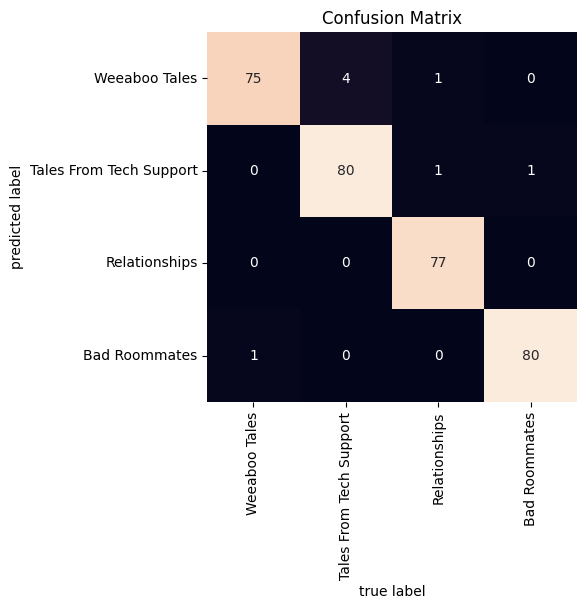

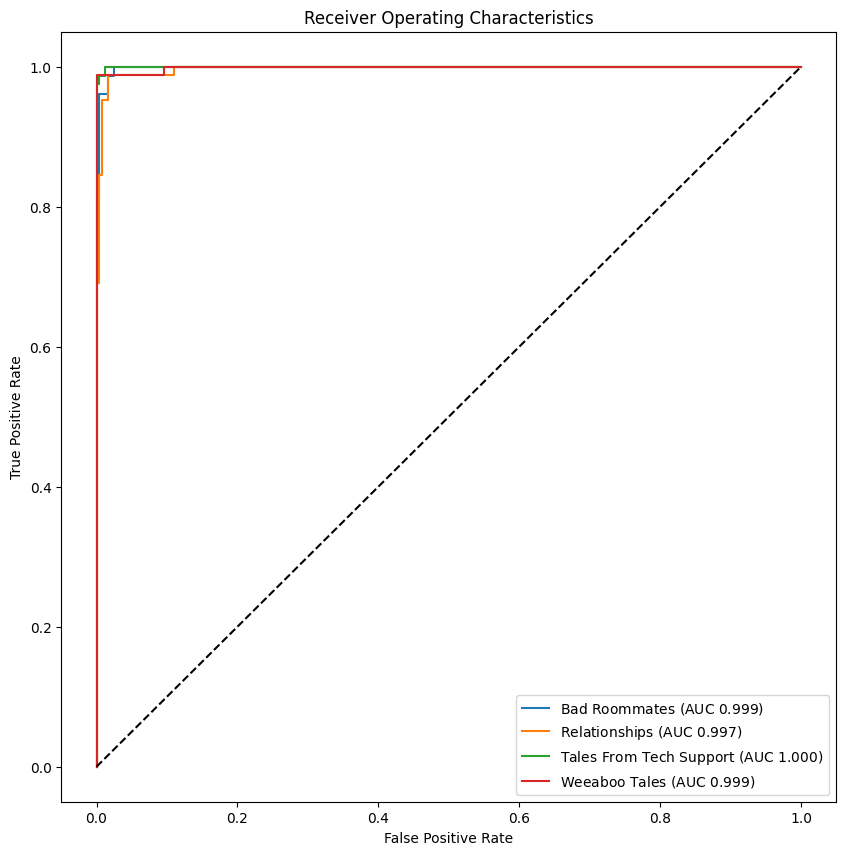

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


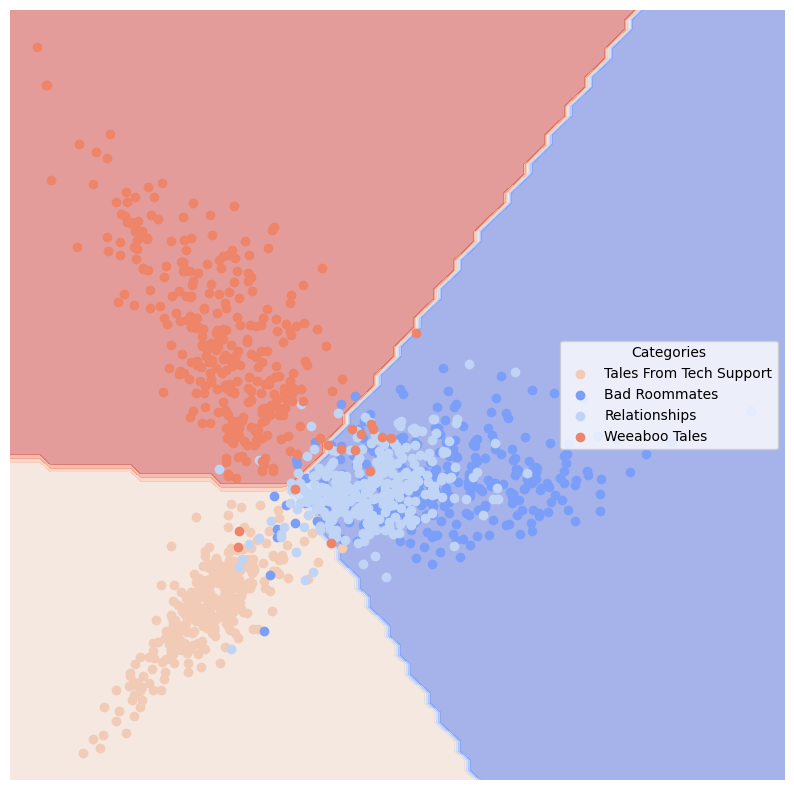

In [74]:
# SVM with Linear Kernel
clf_svm_linear = SVC(kernel='linear', probability=True)
clf_svm_linear.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("SVM Linear Kernel on Dataset", lucem_illud.evaluateClassifier(clf_svm_linear, dfTest))
lucem_illud.plotConfusionMatrix(clf_svm_linear, dfTest)
lucem_illud.plotMultiROC(clf_svm_linear, dfTest)
lucem_illud.plotregions(clf_svm_linear, dfTrain)

K-Nearest Neighbors on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.031250  0.956569   0.952381           0.904686   
Relationships              0.059375  0.912412   0.925000           0.827407   
Bad Roommates              0.062500  0.900538   0.882353           0.772794   
Weeaboo Tales              0.059375  0.947347   0.818182           0.794830   

                           Recall  
Category                           
Tales From Tech Support  0.930233  
Relationships            0.850575  
Bad Roommates            0.833333  
Weeaboo Tales            0.960000  


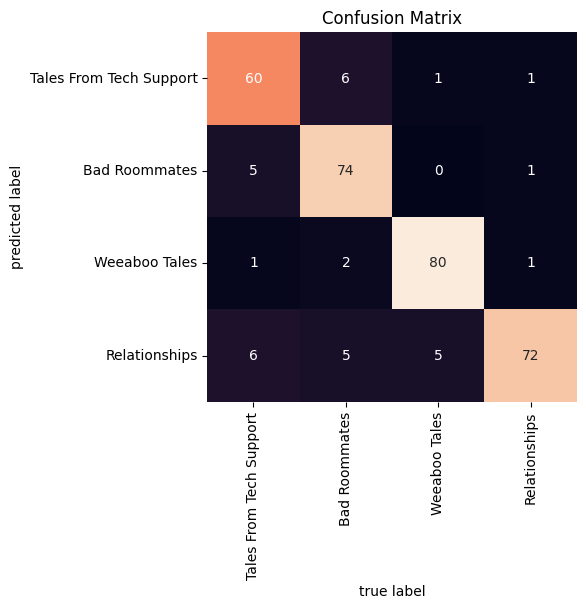

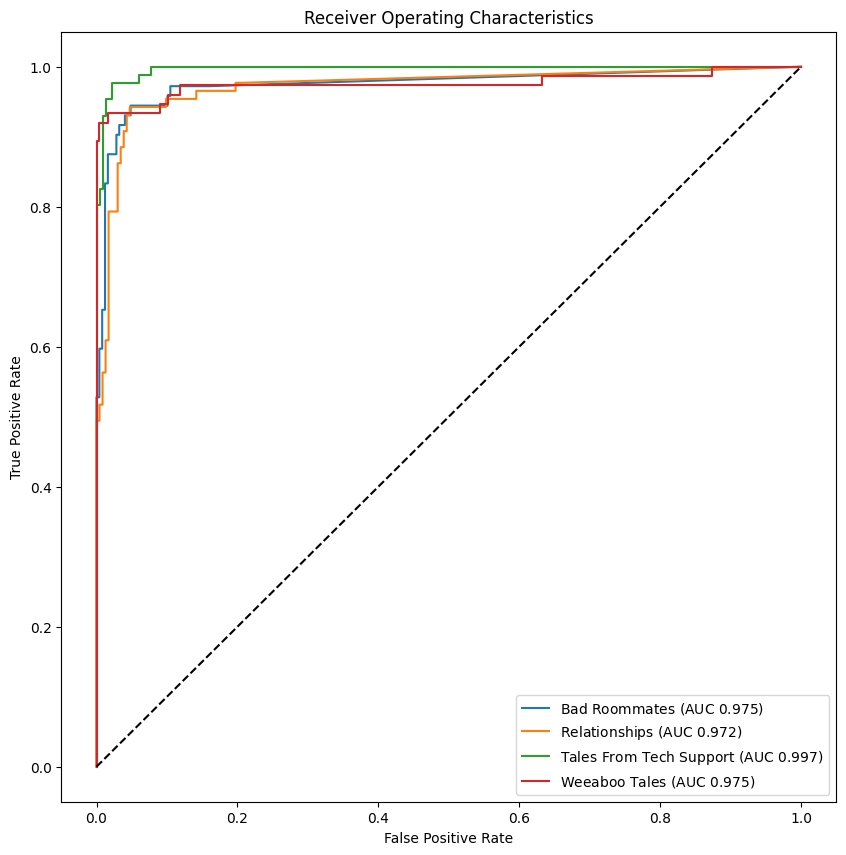

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


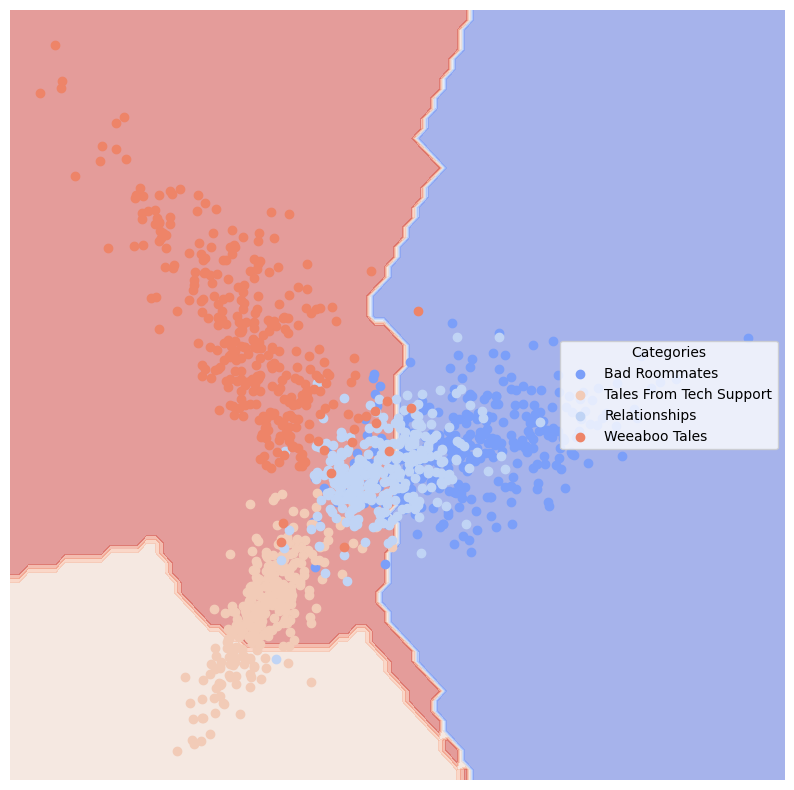

In [10]:
# K-Nearest Neighbors
clf_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf_knn.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("K-Nearest Neighbors on Dataset", lucem_illud.evaluateClassifier(clf_knn, dfTest))
lucem_illud.plotConfusionMatrix(clf_knn, dfTest)
lucem_illud.plotMultiROC(clf_knn, dfTest)
lucem_illud.plotregions(clf_knn, dfTrain)

Decision Tree on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.084375  0.876118   0.883117           0.754528   
Relationships              0.053125  0.941912   0.880435           0.838465   
Bad Roommates              0.062500  0.900538   0.882353           0.772794   
Weeaboo Tales              0.037500  0.966259   0.879518           0.862314   

                           Recall  
Category                           
Tales From Tech Support  0.790698  
Relationships            0.931034  
Bad Roommates            0.833333  
Weeaboo Tales            0.973333  


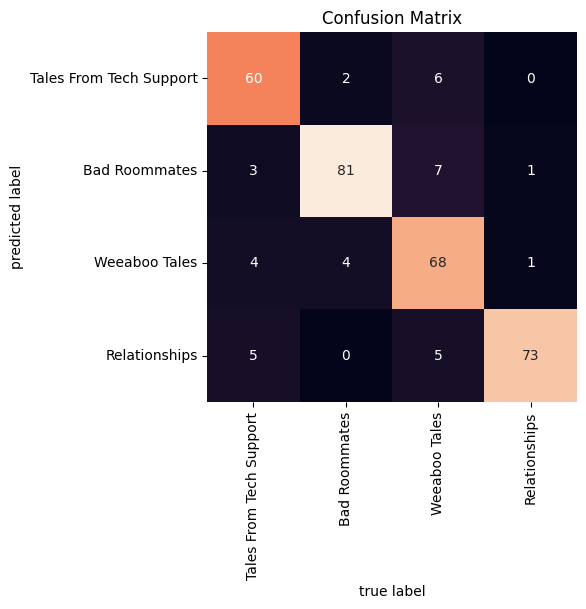

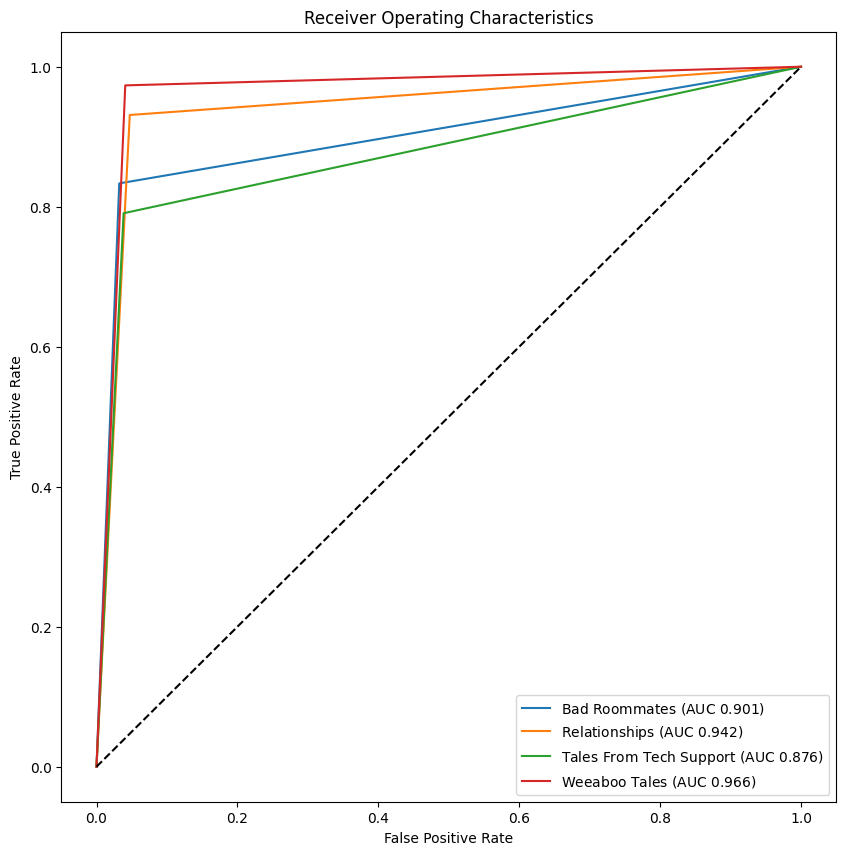

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


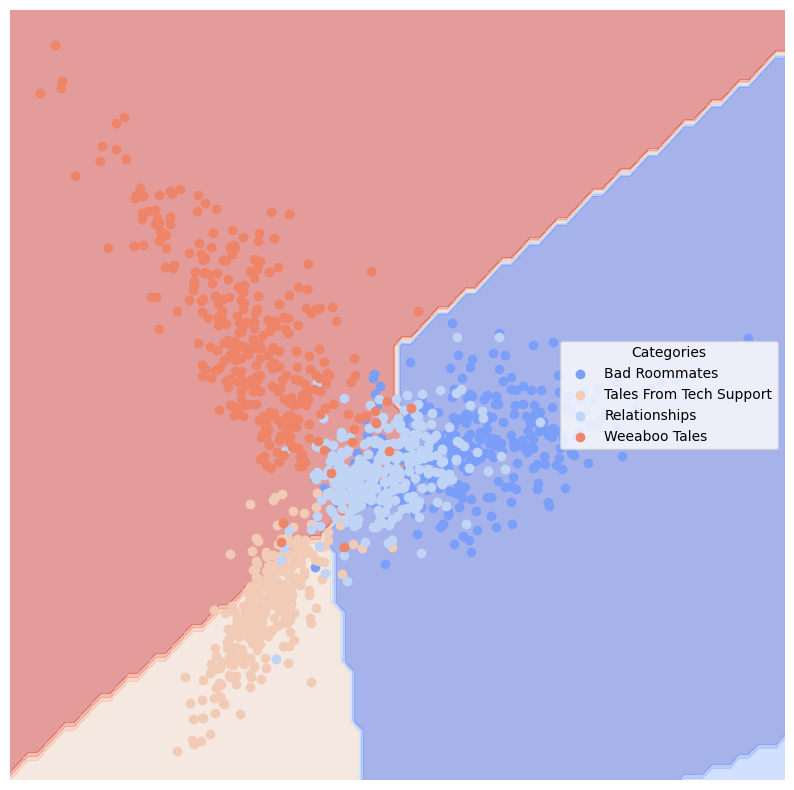

In [11]:
# Decision Tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("Decision Tree on Dataset", lucem_illud.evaluateClassifier(clf_dt, dfTest))
lucem_illud.plotConfusionMatrix(clf_dt, dfTest)
lucem_illud.plotMultiROC(clf_dt, dfTest)
lucem_illud.plotregions(clf_dt, dfTrain)

Random Forest on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.006250  0.992049   0.988372           0.980004   
Relationships              0.015625  0.978467   0.976744           0.952438   
Bad Roommates              0.009375  0.984095   0.985915           0.964779   
Weeaboo Tales              0.012500  0.987211   0.961039           0.951350   

                           Recall  
Category                           
Tales From Tech Support  0.988372  
Relationships            0.965517  
Bad Roommates            0.972222  
Weeaboo Tales            0.986667  


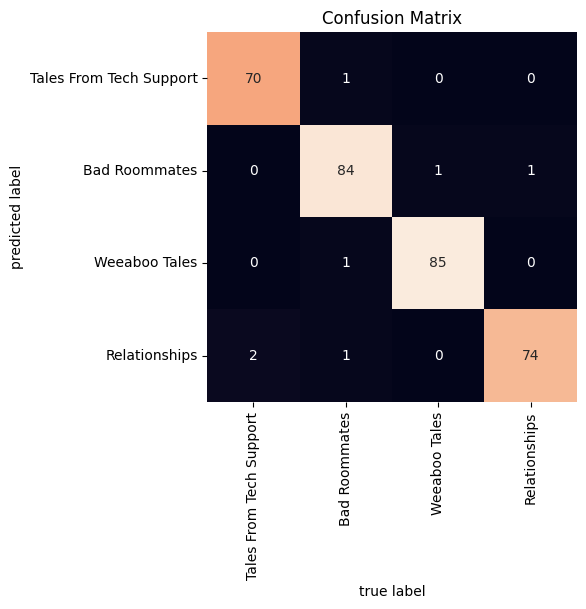

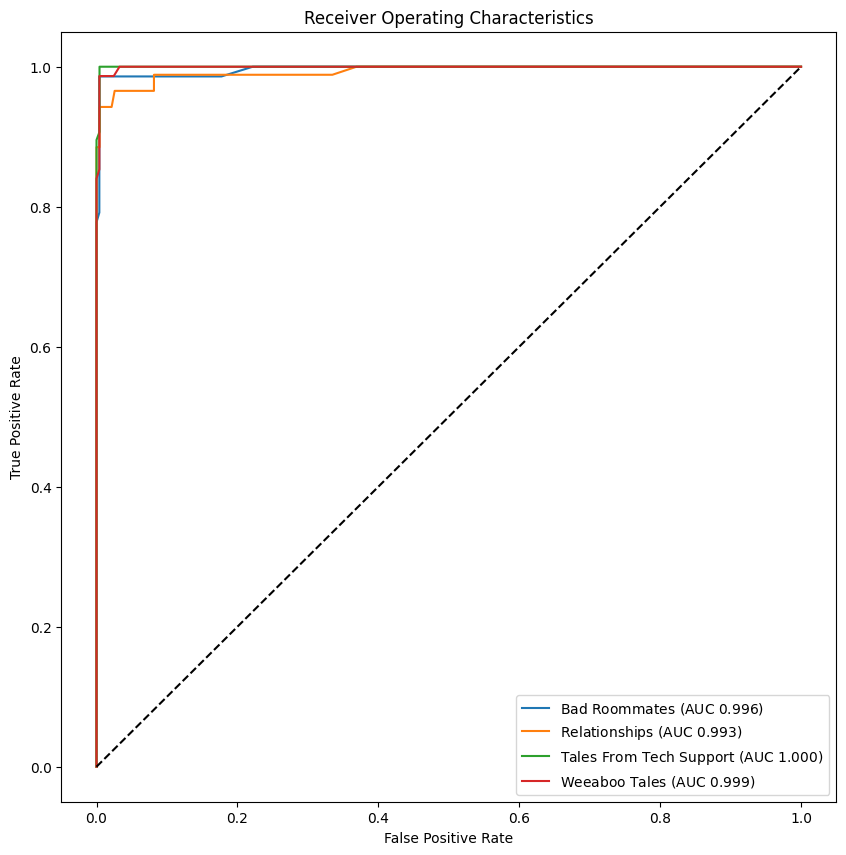

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


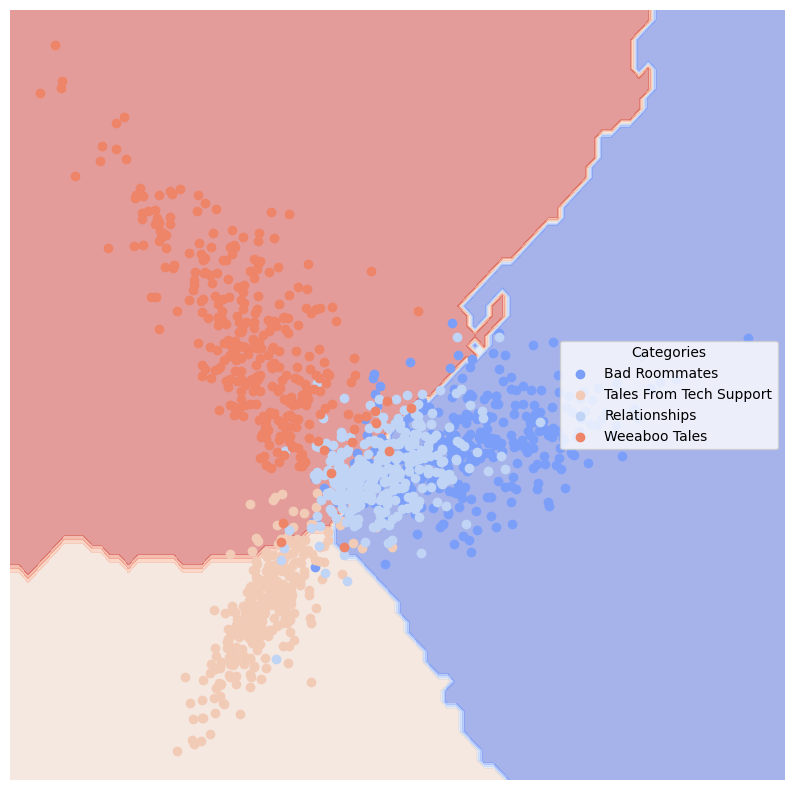

In [12]:
# Random Forest
clf_rf = RandomForestClassifier()
clf_rf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("Random Forest on Dataset", lucem_illud.evaluateClassifier(clf_rf, dfTest))
lucem_illud.plotConfusionMatrix(clf_rf, dfTest)
lucem_illud.plotMultiROC(clf_rf, dfTest)
lucem_illud.plotregions(clf_rf, dfTrain)

MLP on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.006250  0.992049   0.988372           0.980004   
Relationships              0.015625  0.974866   0.988095           0.955166   
Bad Roommates              0.021875  0.966174   0.957746           0.917038   
Weeaboo Tales              0.012500  0.991837   0.949367           0.949367   

                           Recall  
Category                           
Tales From Tech Support  0.988372  
Relationships            0.954023  
Bad Roommates            0.944444  
Weeaboo Tales            1.000000  


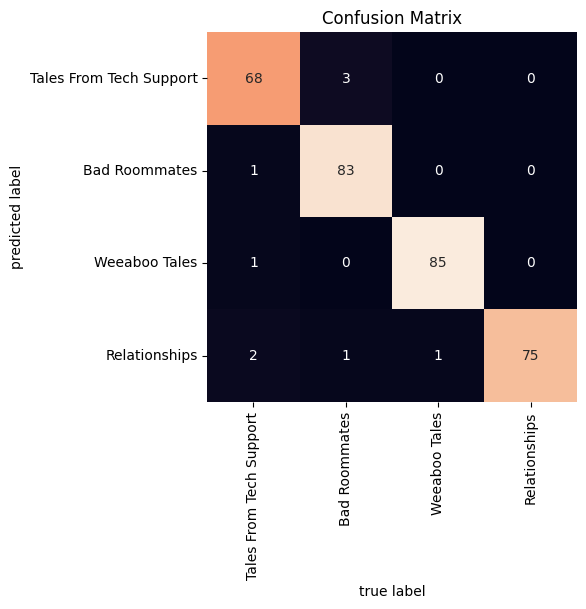

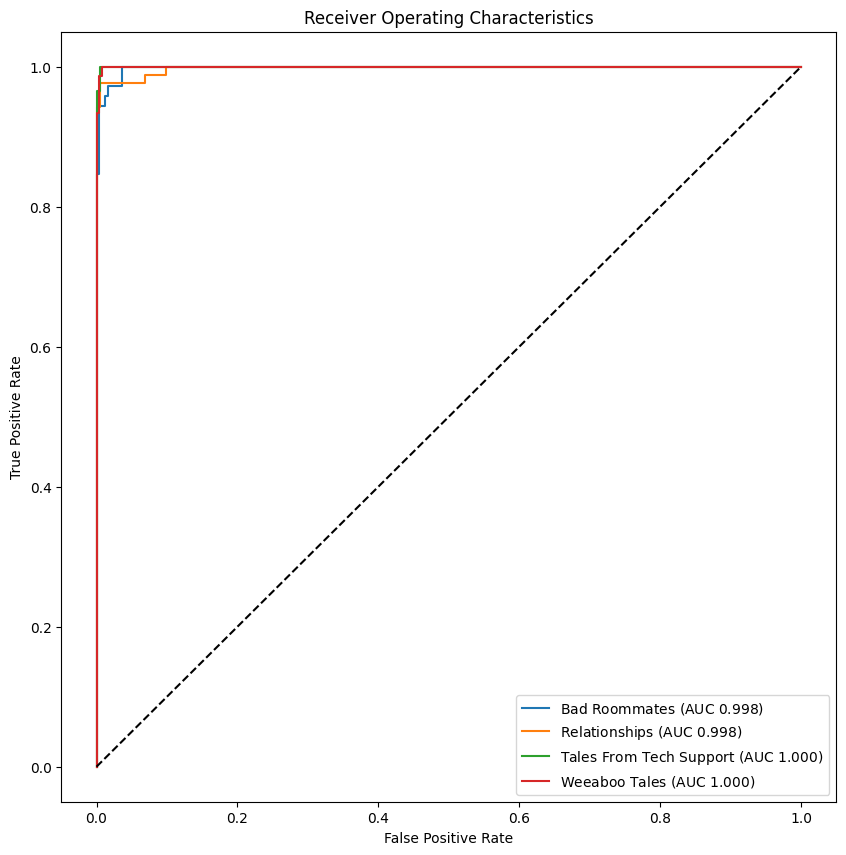

In [13]:
# MLP
clf_mlp = MLPClassifier()
clf_mlp.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("MLP on Dataset", lucem_illud.evaluateClassifier(clf_mlp, dfTest))
lucem_illud.plotConfusionMatrix(clf_mlp, dfTest)
lucem_illud.plotMultiROC(clf_mlp, dfTest)

Gradient Boosting on Dataset                          Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                      
Tales From Tech Support    0.034375  0.961787   0.921348           0.890995   
Relationships              0.018750  0.976321   0.965517           0.941599   
Bad Roommates              0.025000  0.954301   0.970588           0.908456   
Weeaboo Tales              0.009375  0.989252   0.973684           0.963827   

                           Recall  
Category                           
Tales From Tech Support  0.953488  
Relationships            0.965517  
Bad Roommates            0.916667  
Weeaboo Tales            0.986667  


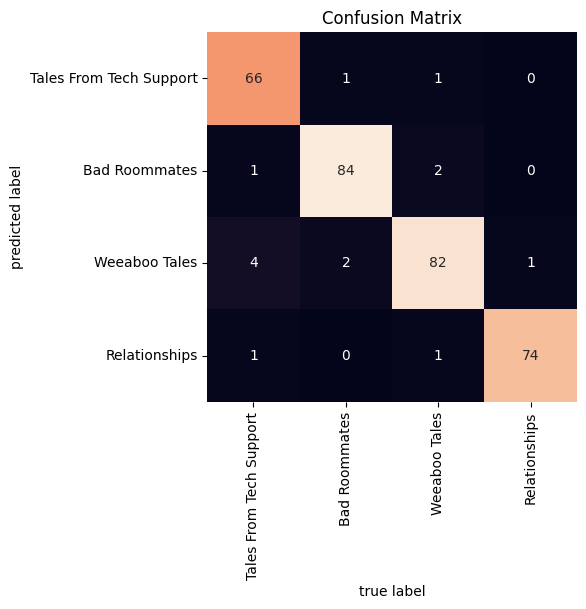

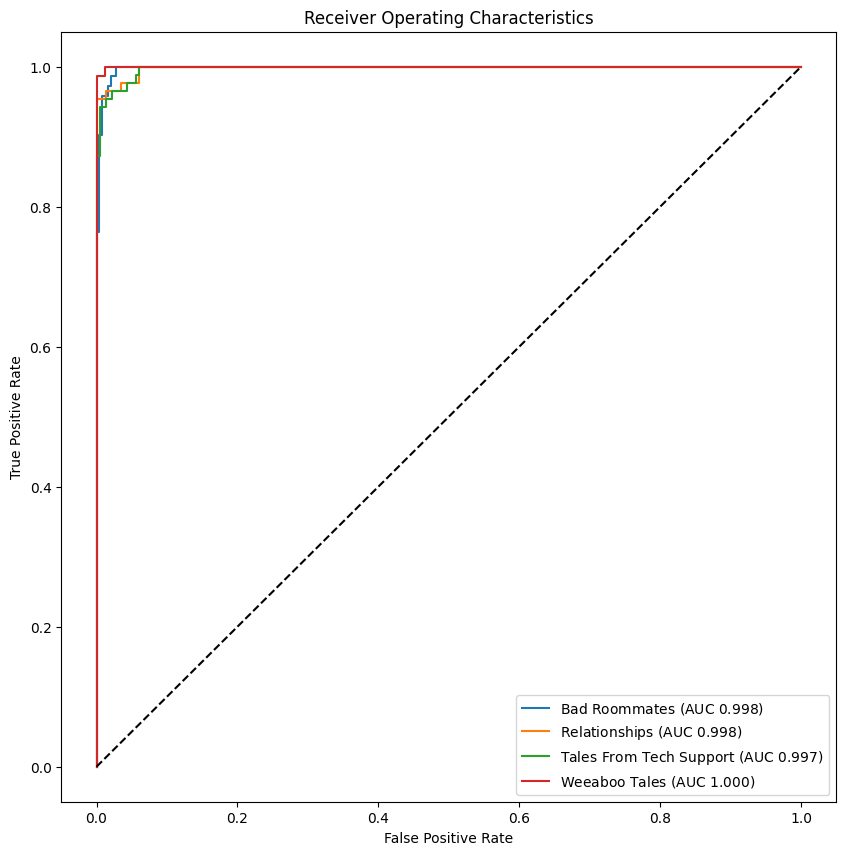

/usr/local/lib/python3.10/dist-packages/lucem_illud/metrics.py:167: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)


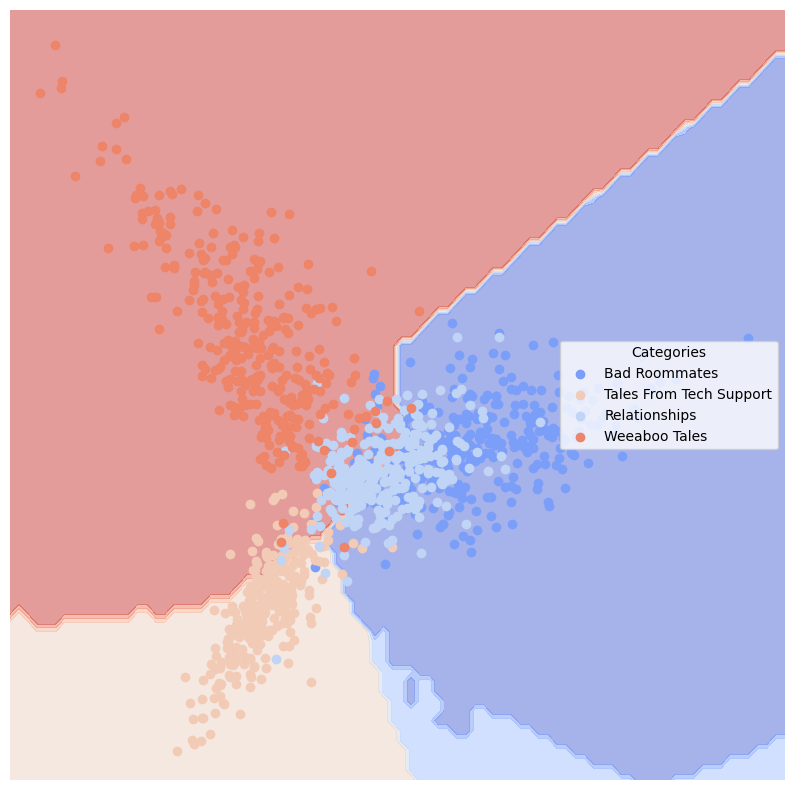

In [14]:
# Gradient Boosting
clf_gb = GradientBoostingClassifier()
clf_gb.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
print("Gradient Boosting on Dataset", lucem_illud.evaluateClassifier(clf_gb, dfTest))
lucem_illud.plotConfusionMatrix(clf_gb, dfTest)
lucem_illud.plotMultiROC(clf_gb, dfTest)
lucem_illud.plotregions(clf_gb, dfTrain)

## Rest of dataset

In [20]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM Linear Kernel": SVC(kernel='linear', probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier()
}

datasets = {
    "Newsgroups": (dfTrain_ng, dfTest_ng),
    "Senate Small": (dfTrain_ss, dfTest_ss),
    "Senate Large": (dfTrain_sl, dfTest_sl),
    "Email Spam": (dfTrain_spam, dfTest_spam)
}

# Evaluate classifiers on each dataset
for dataset_name, (dfTrain, dfTest) in datasets.items():
    X_train, y_train = np.stack(dfTrain['vect'], axis=0), dfTrain['category']
    X_test, y_test = np.stack(dfTest['vect'], axis=0), dfTest['category']
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        print(f"{clf_name} on {dataset_name}", lucem_illud.evaluateClassifier(clf, dfTest))

Logistic Regression on Newsgroups                        Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
comp.sys.mac.hardware    0.059574  0.910750   0.931624           0.829739   
comp.windows.x           0.027660  0.972641   0.915966           0.897815   
misc.forsale             0.057447  0.921294   0.886957           0.809697   
rec.autos                0.055319  0.933343   0.865546           0.810226   

                         Recall  
Category                         
comp.sys.mac.hardware  0.844961  
comp.windows.x         0.973214  
misc.forsale           0.879310  
rec.autos              0.911504  
Naive Bayes on Newsgroups                        Error_Rate       AUC  Precision  Average_Precision  \
Category                                                                    
comp.sys.mac.hardware    0.142553  0.819830   0.742188           0.618913   
comp.windows.x           0.068085  0.92769

## Newsgroups Dataset
**Best Performe**r: SVM with Linear Kernel. It consistently showed high AUC, precision, and recall across categories.

**Why**: The Newsgroups dataset, being textual, likely has linearly separable features in a high-dimensional space, which SVMs, especially with linear kernels, excel at handling.


## Senate Small Dataset
**Best Performers**: Logistic Regression, SVM with Linear Kernel, Decision Tree, Gradient Boosting, and Random Forest showed similar high performance with very low error rates and high precision and recall.

**Why**: The Senate Small dataset may have clear, well-defined decision boundaries that allow both linear models (like Logistic Regression and SVM with Linear Kernel) and ensemble methods (like Random Forest and Gradient Boosting) to perform well.


## Senate Large Dataset
**Best Performers**: Decision Tree, Random Forest, Gradient Boosting, and SVM with Linear Kernel. These classifiers achieved nearly perfect or perfect performance metrics.

**Why**: The Senate Large dataset likely contains distinct patterns and relationships that are well-captured by the decision rules of Decision Trees and the ensemble methods that build upon them, such as Random Forest and Gradient Boosting.

## Email Spam Dataset
**Best Performer**: MLP (Multi-Layer Perceptron). It showed the highest AUC and a good balance between precision and recall, particularly in identifying spam.

**Why**: The Email Spam dataset contains patterns and possibly non-linear relationships that are well-suited to MLP's capabilities.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest?

In [27]:
ObamaClintonReleases = pandas.read_csv('/content/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame.

In [28]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [29]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [30]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [31]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Let's split the data into training data and testing data.

In [32]:
holdBackFraction = .2
train_data_df, test_data_df = sklearn.model_selection.train_test_split(ObamaClintonReleases, test_size=holdBackFraction)

In [33]:
print(len(train_data_df))
print(len(test_data_df))

1367
342


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [ ]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents.

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean?

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1.

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform.

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [ ]:
TFVects.shape

We can save this in the dataframe to make things easier

In [ ]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [ ]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [ ]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")

ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

In [ ]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [ ]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [ ]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [ ]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [ ]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

Slightly poorer. How about using more dimensions (40)?

In [ ]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Or still more (100)?

In [ ]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Or even more (200)!

In [ ]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

This is becoming ridiculous (400)!

In [ ]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [ ]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

Train the model using training data, and then test it on the testing data.

In [ ]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

81% accuracy seems like the best we can get by using a logistic regression.

## <font color="red">*Exercise 3*</font>

<font color="red">In the cells immediately following, perform logistic regression classification using training, testing and uncoded (i.e., data you didn't code by hand but want to use your model on) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk in Exercise 1). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [44]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [34]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

# List of page URLs
initial_url = "https://www.psychforums.com/bipolar/topic67945.html"
pages_link = [initial_url] + ["https://www.psychforums.com/bipolar/topic67945-" + str(i*10) + ".html" for i in range(1, 500)]

content_data = []

# Loop through each page and scrape content
for url in pages_link:
    forum_post_request = requests.get(url)
    page_soup = BeautifulSoup(forum_post_request.text, 'html.parser')
    content_divs = page_soup.findAll('div', {'class': re.compile('post bg[12]')})

    for div in content_divs:
        # Find the date
        author_info = div.find('p', {'class': 'author'})
        if author_info:
            date_strong = author_info.find('strong')
            if date_strong and date_strong.next_sibling:
                date_text = date_strong.next_sibling.strip()

        # Find the content
        content_div = div.find('div', {'class': 'content'})
        if content_div:
            post_text = content_div.get_text(strip=True)
            # Apply cleaning transformations
            cleaned_text = re.sub(r'https?://\S+|www\.\S+', '[URL]', post_text)
            cleaned_text = re.sub(r'!+', '!', cleaned_text)
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
            content_data.append({'date': date_text, 'text': cleaned_text})

# Convert to a DataFrame
content_data_df = pd.DataFrame(content_data)

In [38]:
content_data_df.to_csv('content_data_df.csv', index=False)

In [40]:
content_data_df['tokenized_text'] = content_data_df['text'].apply(lambda x: lucem_illud.word_tokenize(x))
content_data_df['normalized_text'] = content_data_df['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [41]:
def classify_sentiment(text):
    # Define keywords related to positive and negative sentiments
    positive_keywords = ['happy', 'joy', 'positive', 'good', 'wonderful', 'great', 'love']
    negative_keywords = ['sad', 'depressed', 'negative', 'bad', 'terrible', 'hate', 'worry', 'anxious']


    text_lower = text.lower()


    positive_present = any(keyword in text_lower for keyword in positive_keywords)
    negative_present = any(keyword in text_lower for keyword in negative_keywords)

    # Classify based on the presence of keywords
    if positive_present and not negative_present:
        return 1  # Positive sentiment
    elif negative_present and not positive_present:
        return 0  # Negative sentiment
    else:
        return -1


content_data_df['sentiment_label'] = content_data_df['text'].apply(classify_sentiment)


sentiment_label_distribution = content_data_df['sentiment_label'].value_counts(normalize=True)

sentiment_label_distribution, content_data_df[['text', 'sentiment_label']].head()

(-1    0.5952
  1    0.2508
  0    0.1540
 Name: sentiment_label, dtype: float64,
                                                 text  sentiment_label
 0  Thought I'd make a general "check up" topic fo...               -1
 1  Partrly sunny with scattered anxiety.It was a ...               -1
 2  Interesting question, at the start of the week...               -1
 3  Good to know that you guys aren't doing all th...               -1
 4  I woke up not feeling too good at all. I woke ...               -1)

In [45]:
filtered_data_df = content_data_df[content_data_df['sentiment_label'] >= 0]

# Split the filtered dataset into training and testing sets
train_data_df, test_data_df = train_test_split(filtered_data_df, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Splitting the data into training and testing sets
train_data_df, test_data_df = train_test_split(content_data_df[content_data_df['sentiment_label'] >= 0], test_size=0.2, random_state=42)


# Fit and transform the training data with TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data_df['text'])

# Transform the testing data with TF-IDF
X_test_tfidf = tfidf_vectorizer.transform(test_data_df['text'])

# Initialize PCA for dimensionality reduction, aiming to retain 95% of variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
X_test_pca = pca.transform(X_test_tfidf.toarray())

# Training the logistic regression model
y_train = train_data_df['sentiment_label']
y_test = test_data_df['sentiment_label']
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_pca, y_train)

# Predictions and evaluations
y_train_pred = logistic_model.predict(X_train_pca)
y_test_pred = logistic_model.predict(X_test_pca)

# Calculating metrics
train_accuracy_sentiment = logistic_model.score(X_train_pca, y_train)
test_accuracy_sentiment = logistic_model.score(X_test_pca, y_test)
precision_sentiment, recall_sentiment, fscore_sentiment, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
auc_score_sentiment = roc_auc_score(y_test, logistic_model.predict_proba(X_test_pca)[:, 1])


(train_accuracy_sentiment, test_accuracy_sentiment, precision_sentiment, recall_sentiment, fscore_sentiment, auc_score_sentiment)

(0.9641754169240272,
 0.8790123456790123,
 0.8374558303886925,
 0.9875,
 0.9063097514340344,
 0.980530303030303)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

In [ ]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = sklearn.model_selection.train_test_split(blobs_df, test_size=.2)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [ ]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

To see what's going on visually with the classification:

In [ ]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [ ]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

Lets look at accuracy:

In [ ]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

What happens if we trim the tree?

In [ ]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [ ]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [ ]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

In [ ]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [ ]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

In [ ]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <font color="red">*Exercise 4*</font>

<font color="red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split




# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # Limiting to 1000 features for simplicity
X = tfidf_vectorizer.fit_transform(content_data_df['text'])
y = content_data_df['sentiment_label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Classifier
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = clf_tree.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.91      0.92      0.92       603
           0       0.88      0.84      0.86       143
           1       0.88      0.88      0.88       254

    accuracy                           0.90      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.90      0.90      0.90      1000



AUC (One-vs-Rest): 0.9743212224008874


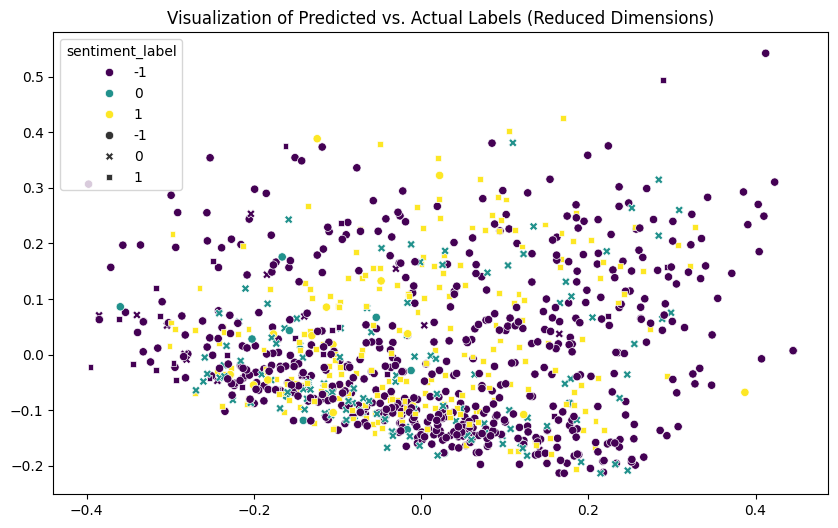

In [50]:
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# Split the reduced data for training and testing
X_train_red, X_test_red, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Bagging Classifier (Random Forest-like)
clf_bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
clf_bag.fit(X_train, y_train)  # Note: Using original high-dimensional data for training

# Predict on the test set
y_pred = clf_bag.predict(X_test)


classes = np.unique(y_test)  # Get the list of unique classes
y_test_binarized = label_binarize(y_test, classes=classes)  # Binarize the output

auc_ovr = roc_auc_score(y_test_binarized, clf_bag.predict_proba(X_test), multi_class='ovr')

print("AUC (One-vs-Rest):", auc_ovr)



plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_red[:, 0], y=X_test_red[:, 1], hue=y_pred, style=y_test, palette="viridis")
plt.title('Visualization of Predicted vs. Actual Labels (Reduced Dimensions)')
plt.show()

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = clf_rf.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='weighted')


auc = roc_auc_score(y_test, clf_rf.predict_proba(X_test), multi_class='ovr')

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F-score: {fscore}, AUC: {auc}")

Accuracy: 0.819, Precision: 0.8432581263745415, Recall: 0.819, F-score: 0.8066621660970544, AUC: 0.9319717986178965


In [54]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


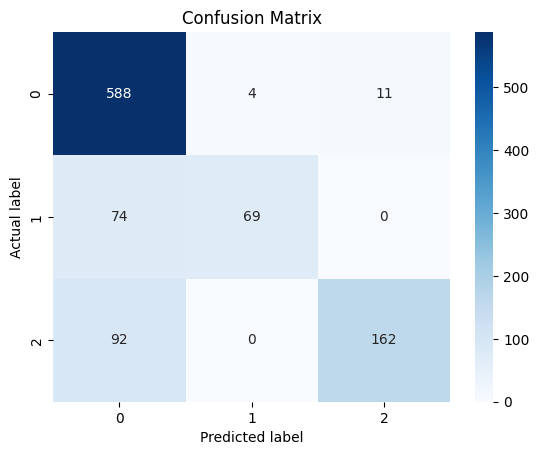

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

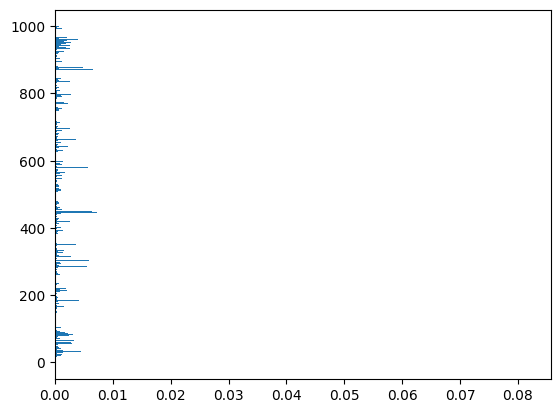

In [58]:
plt.barh(range(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.show()

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data.

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus. # replace path if on Colab
newsgroups.target_names #Possible categories, i.e., the newsgroups

target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [ ]:
newsgroupsDF[:5]

Make a testing and training set:

In [ ]:
holdBackFraction = .2
train_ng_df, test_ng_df = sklearn.model_selection.train_test_split(newsgroupsDF, test_size=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [ ]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [ ]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

And lets look at the testing data

In [ ]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Let's produce another confusion matrix:

In [ ]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <font color="red">*Exercise 5*</font>

<font color="red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c0c90438f70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


Training Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.05      0.10      2373
           0       0.16      0.98      0.28       627
           1       0.20      0.00      0.00      1000

    accuracy                           0.19      4000
   macro avg       0.40      0.35      0.13      4000
weighted avg       0.57      0.19      0.10      4000

Test Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.04      0.08       603
           0       0.15      0.99      0.25       143
           1       0.00      0.00      0.00       254

    accuracy                           0.17      1000
   macro avg       0.33      0.34      0.11      1000
weighted avg       0.54      0.17      0.08      1000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  beta : float
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  beta : float
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  beta : float


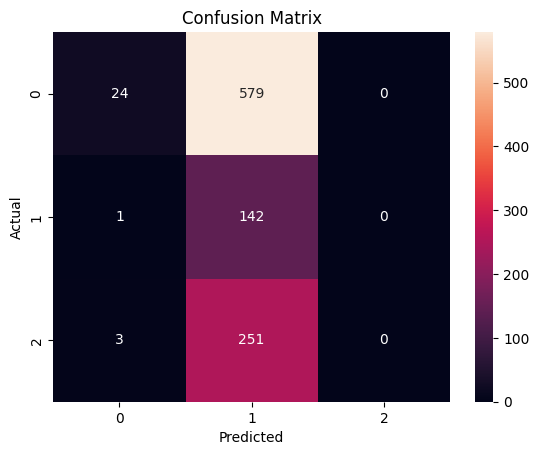

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=2, stop_words='english', norm='l2')
X = tfidf_vectorizer.fit_transform(content_data_df['text'])
y = content_data_df['sentiment_label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN Classifier
n_neighbors = 15
clf_knearest = KNeighborsClassifier(n_neighbors, weights="uniform")
clf_knearest.fit(X_train, y_train)

# Evaluation on the training set
y_pred_train = clf_knearest.predict(X_train)
print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))

# Evaluation on the test set
y_pred_test = clf_knearest.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**K-Nearest Neighbors** is a supervised learning algorithm used for classification (and regression) tasks. It classifies a data point based on how its neighbors are classified. KNN relies on labeled data to make predictions.

**K-Means Clustering** is an unsupervised learning algorithm used for clustering tasks. It groups data points into k number of clusters based on feature similarity. K-Means doesn't require labeled data and instead discovers the inherent groupings in the data.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [ ]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0) # replace path if on Colab

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [ ]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [ ]:
holdBackFraction = .2
train_redditDf, test_redditDf = sklearn.model_selection.train_test_split(redditDf, test_size=holdBackFraction)

In [ ]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

...and consider the results:

In [ ]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $z = w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $f(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

<img src="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" alt="https://github.com/UChicago-Computational-Content-Analysis/Homework-Notebooks-2024-Winter/blob/main/data/MLP.jpg?raw=true" style="width:500px">

In [ ]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

In [ ]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

In [ ]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <font color="red">*Exercise 6*</font>

<font color="red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, logistic and decision-tree approaches?

Classification Report:
              precision    recall  f1-score   support

          -1       0.80      0.83      0.82       603
           0       0.69      0.66      0.68       143
           1       0.75      0.70      0.73       254

    accuracy                           0.78      1000
   macro avg       0.75      0.73      0.74      1000
weighted avg       0.77      0.78      0.77      1000



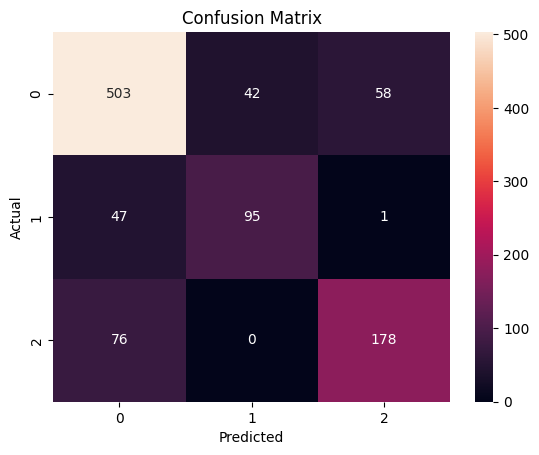

AUC calculation issue, possibly due to a multi-class problem.


In [60]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the MLPClassifier
clf_nn = MLPClassifier(random_state=42, max_iter=300)


clf_nn.fit(X_train, y_train)

# Predictions
y_pred = clf_nn.predict(X_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


try:
    auc_score = roc_auc_score(y_test, clf_nn.predict_proba(X_test)[:, 1])
    print("AUC:", auc_score)
except ValueError:

    print("multi-class problem.")

**Neural Networks** are highly flexible and capable of modeling complex non-linear relationships. They can capture deep interactions between features but require more data and computational resources.

**KNN** is a simple, intuitive method that classifies based on the nearest neighbors in the feature space. It's computationally expensive at prediction time and doesn't perform well on high-dimensional data due to the curse of dimensionality.

**Logistic Regression** is a linear model for binary classification that can be extended to multi-class problems using schemes like one-vs-rest.

**Decision Trees** are easy to interpret and can model non-linear relationships. However, they can easily overfit the training data.

## Classification with BERT Pipelines
Now, instead of classifying based on "old" NLP methods, we will now use the popular Transformers package default 'pipelines'. This package has methods for a wide range of common NLP tasks using contextual word embeddings. Note that for this homework, we are not building new contextual models ourselves, merely using existing models in Transformers. We will spend Weeks 7 and 8 learning more about Transformers, so do not worry about fully understanding them this week.

[Transformers Documentation](https://huggingface.co/transformers/)

[Transformers GitHub](https://github.com/huggingface/transformers)

The following sections of code are taken from the [Summary of Tasks](https://huggingface.co/transformers/task_summary.html) page in the Transformers documentation.

### Sequence Classification (e.g., sentiment)
Sequence classification is the task of classifying sequences according to a given number of classes. An example of
sequence classification is the GLUE dataset. If you would like to fine-tune a
model on a GLUE sequence classification task, you may leverage the [pytorch version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/pytorch/text-classification/run_glue.py) and
[pytorch-lightning version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/pytorch-lightning/run_glue.py)(legacy) or
[tensorflow version run_glue.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/tensorflow/text-classification/run_glue.py) scripts.

Here is an example of using pipelines to do sentiment analysis: identifying if a sentence is positive or negative. It
leverages a fine-tuned model on sst2, which is a GLUE task.

This returns a label ("POSITIVE" or "NEGATIVE") alongside a score, as follows:

In [ ]:
from transformers import pipeline
nlp = pipeline("sentiment-analysis")
result = nlp("I hate you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")
result = nlp("I love you")[0]
print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

Here is an example of doing a sequence classification using a model to determine if two sequences are paraphrases of
each other. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Build a sequence from the two sentences, with the correct model-specific separators token type ids and attention
   masks (`PreTrainedTokenizer.encode` and `PreTrainedTokenizer.__call__` take
   care of this).
3. Pass this sequence through the model so that it is classified in one of the two available classes: 0 (not a
   paraphrase) and 1 (is a paraphrase).
4. Compute the softmax of the result to get probabilities over the classes.
5. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased-finetuned-mrpc")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased-finetuned-mrpc")
classes = ["not paraphrase", "is paraphrase"]
sequence_0 = "The company HuggingFace is based in New York City"
sequence_1 = "Apples are especially bad for your health"
sequence_2 = "HuggingFace's headquarters are situated in Manhattan"
paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")
paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits
paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]
# Should be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")
# Should not be paraphrase
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

### Extractive Question Answering

Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune a
model on a SQuAD task, you may leverage the [run_squad.py](https://github.com/huggingface/transformers/blob/f40b87de0ca234df61f76928956c4a2118c0b548/examples/legacy/question-answering/run_squad.py) (legacy) script.


Here is an example of using pipelines to do question answering: extracting an answer from a text given a question. It
leverages a fine-tuned model on SQuAD.

In [ ]:
from transformers import pipeline
nlp = pipeline("question-answering")
context = r"""
Extractive Question Answering is the task of extracting an answer from a text given a question. An example of a
question answering dataset is the SQuAD dataset, which is entirely based on that task. If you would like to fine-tune
a model on a SQuAD task, you may leverage the examples/legacy/question-answering/run_squad.py
"""

This returns an answer extracted from the text, a confidence score, alongside "start" and "end" values, which are the
positions of the extracted answer in the text.

In [ ]:
result = nlp(question="What is extractive question answering?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")
result = nlp(question="What is a good example of a question answering dataset?", context=context)
print(f"Answer: '{result['answer']}', score: {round(result['score'], 4)}, start: {result['start']}, end: {result['end']}")

Here is an example of question answering using a model and a tokenizer. The process is the following:

1. Instantiate a tokenizer and a model from the checkpoint name. The model is identified as a BERT model and loads it
   with the weights stored in the checkpoint.
2. Define a text and a few questions.
3. Iterate over the questions and build a sequence from the text and the current question, with the correct
   model-specific separators token type ids and attention masks.
4. Pass this sequence through the model. This outputs a range of scores across the entire sequence of tokens (question and
   text), for both the start and end positions.
5. Compute the softmax of the result to get probabilities over the tokens.
6. Fetch the tokens from the identified start and stop values, convert those tokens to a string.
7. Print the results.

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
text = r"""
🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose
architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural
Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between
TensorFlow 2.0 and PyTorch.
"""
questions = [
    "How many pretrained models are available in 🤗 Transformers?",
    "What does 🤗 Transformers provide?",
    "🤗 Transformers provides interoperability between which frameworks?",
]
for question in questions:
    inputs = tokenizer(question, text, add_special_tokens=True, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]

    text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    answer_start = torch.argmax(
        answer_start_scores
    )  # Get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score

    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

    print(f"Question: {question}")
    print(f"Answer: {answer}")

## <font color="red">*Exercise 7*</font>

<font color="red">In the cells immediately following, use the pipeline functions or the word or sentence vector functions (e.g., similarity) to explore the social game underlying the production and meaning of texts associated with your final project. How does BERT help you gain insight regarding your research question that is similar and different from prior methods?

In [61]:
from transformers import pipeline

# Initialize the question-answering pipeline with BERT
qa_pipeline = pipeline("question-answering", model="bert-large-uncased-whole-word-masking-finetuned-squad")


context = """
I don't know... I'm having some mixed feelings right now. On the good side I made it past the 21st. I had originally thought that may have been a really bad day for me but I got throught it unscathed. There are no more foreseeable bad days in the near future so I think I'm good.On the bad side I'm getting impatient. My life isn't where I'd like it to be so I'd like to get on with it. Everything is years down the road and I'm just starting.
I wish I could just cut this part of my life out and start at the end when everything is already finished. It doesn't work that way and everyday is a trial to keep at it. The end will be sweeter for it I suppose.
"""


questions = [
    "What positive experience is mentioned?",
    "What challenges is the individual facing?",
    "What does the individual wish for their future?",
    "How does the individual view the process of achieving their goals?"
]

# Get answers to each question based on the context
for question in questions:
    result = qa_pipeline(question=question, context=context)
    print(f"Question: {question}")
    print(f"Answer: '{result['answer']}', Score: {round(result['score'], 4)}\n")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Question: What positive experience is mentioned?
Answer: 'I made it past the 21st', Score: 0.3098

Question: What challenges is the individual facing?
Answer: 'I'm getting impatient', Score: 0.0299

Question: What does the individual wish for their future?
Answer: 'I could just cut this part of my life out and start at the end', Score: 0.0555

Question: How does the individual view the process of achieving their goals?
Answer: 'a trial', Score: 0.188



BERT's question-answering can help identify specific sentiments and themes within the text, such as resilience through personal challenges, the desire for immediate progress, and the recognition of long-term rewards. This approach allows for a granular analysis of text, providing direct answers that might not be as easily extracted through other NLP methods like sentiment analysis or topic modeling.